# **Importing all necessary libraries**

In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA,IncrementalPCA,SparsePCA,MiniBatchSparsePCA,KernelPCA,TruncatedSVD,DictionaryLearning,\
MiniBatchDictionaryLearning,FactorAnalysis,FastICA,NMF,LatentDirichletAllocation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

2024-04-17 07:09:27.419883: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 07:09:27.419978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 07:09:27.545377: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Definign all necessary functions and classes**

In [2]:
def estimate(X,y,model=RandomForestClassifier(max_depth=3)):
    scores=cross_val_score(model,X,y,scoring='f1',cv=5)
    return scores.mean(),scores.std()

In [3]:
def visualize(X,y,method):
    fig=plt.figure(figsize=(10,10))
    ax=fig.add_subplot(projection='3d')
    mask1=(y==0)
    mask2=(y==1)
    ax.scatter(X[mask1,0],X[mask1,1],X[mask1,2],color='r',label='0')
    ax.scatter(X[mask2,0],X[mask2,1],X[mask2,2],color='g',label='1')
    ax.grid()
    ax.legend()
    ax.set_title(method)
    plt.show()

In [4]:
class LinearAutoEncoder(tf.keras.Model):
    def __init__(self,input_dim,hidden_dim=3):
        super(LinearAutoEncoder,self).__init__()
        self.hidden_dim=hidden_dim
        self.input_dim=input_dim
        self.encoder=tf.keras.Sequential([tf.keras.layers.Dense(units=2*self.hidden_dim,activation='linear'),
                                          tf.keras.layers.Dense(units=self.hidden_dim,activation='linear')])
        self.decoder=tf.keras.Sequential([tf.keras.layers.Dense(units=2*self.hidden_dim,activation='linear'),
                                          tf.keras.layers.Dense(units=self.input_dim,activation='linear')])
    def call(self,x):
        h=self.encoder(x)
        Out=self.decoder(h)
        return Out

In [5]:
class NonLinearAutoEncoder(tf.keras.Model):
    def __init__(self,input_dim,hidden_dim=3):
        super(NonLinearAutoEncoder,self).__init__()
        self.hidden_dim=hidden_dim
        self.input_dim=input_dim
        self.encoder=tf.keras.Sequential([tf.keras.layers.Dense(units=2*self.hidden_dim,activation='leaky_relu'),
                                          tf.keras.layers.Dense(units=self.hidden_dim,activation='linear')])
        self.decoder=tf.keras.Sequential([tf.keras.layers.Dense(units=2*self.hidden_dim,activation='leaky_relu'),
                                          tf.keras.layers.Dense(units=self.input_dim,activation='linear')])
    def call(self,x):
        h=self.encoder(x)
        Out=self.decoder(h)
        return Out

# **First dataset**

In [6]:
methods=[]
f1s=np.zeros(shape=17)
stds=np.zeros(shape=17)

## **Analyzing dataset**

In [7]:
df=pd.read_csv('/kaggle/input/winequality/winequality-red.csv',delimiter=';')
display(df)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  
0         9.4        5  
1         9.8        5  
2         9.8        5  
3         9.8        6  
4         9.4        5  
...       ...      ...  
1594     10.5        5  
1595     11.2        6  
1596     11.0        6  
1597     10.2        5  
1598     11.0        6  

[1599 rows x 12 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [9]:
y=df.quality.values
X=df.drop(['quality'],axis=1)
print(y)
display(X)

[5 5 5 ... 6 5 6]


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  
0         9.4  
1         9.8  
2         9.8  
3         9.8  
4         9.4  
...       ...  
1594     10.5  
1595     11.2  
1596     11.0  
1597     10.2  
1598     11.0  

[1599 rows x 11 columns]

In [10]:
qualities=np.unique(y)
print(qualities)

[3 4 5 6 7 8]


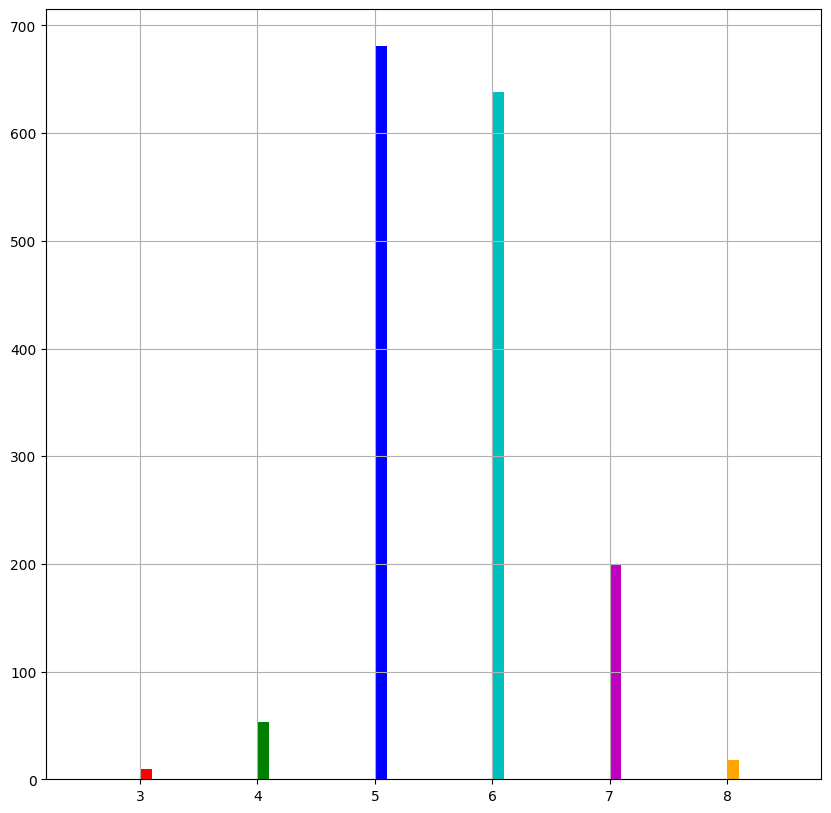

In [11]:
colors=['r','g','b','c','m','orange','yellow']
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.grid()
for i in range(len(qualities)):
    ax.hist(y[y==qualities[i]],color=colors[i])
plt.xticks(qualities)
plt.show()

In [12]:
y[y<=5]=0
y[y>=6]=1
print(y)

[0 0 0 ... 1 0 1]


## **Preprocessing of the dataset, using StandardScaler**

In [13]:
X__=X.copy()
for col in X.columns:
    X[col]=StandardScaler().fit_transform(X[col].values.reshape(-1,1)).reshape(-1,1)
X=X.values
for col in X__.columns:
    X__[col]=MinMaxScaler().fit_transform(X__[col].values.reshape(-1,1)).reshape(-1,1)

## **Original dataset**

In [14]:
f1s[0],stds[0]=estimate(X,y)
methods.append('Original Dataset')
print(f1s[0],stds[0])

0.7532427583137373 0.048924539775917465


## **PCA**

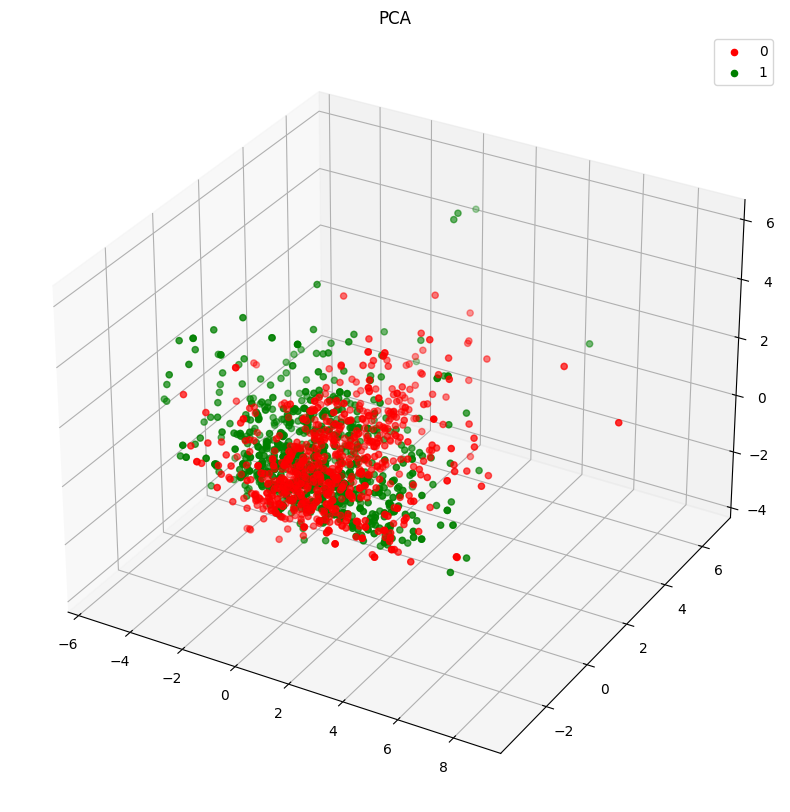

0.7051394734923658 0.059064977354241564


In [15]:
reducer=PCA(n_components=3)
X_=reducer.fit_transform(X)
f1s[1],stds[1]=estimate(X_,y)
visualize(X_,y,'PCA')
print(f1s[1],stds[1])
methods.append('PCA')

## **Randomized SVD**

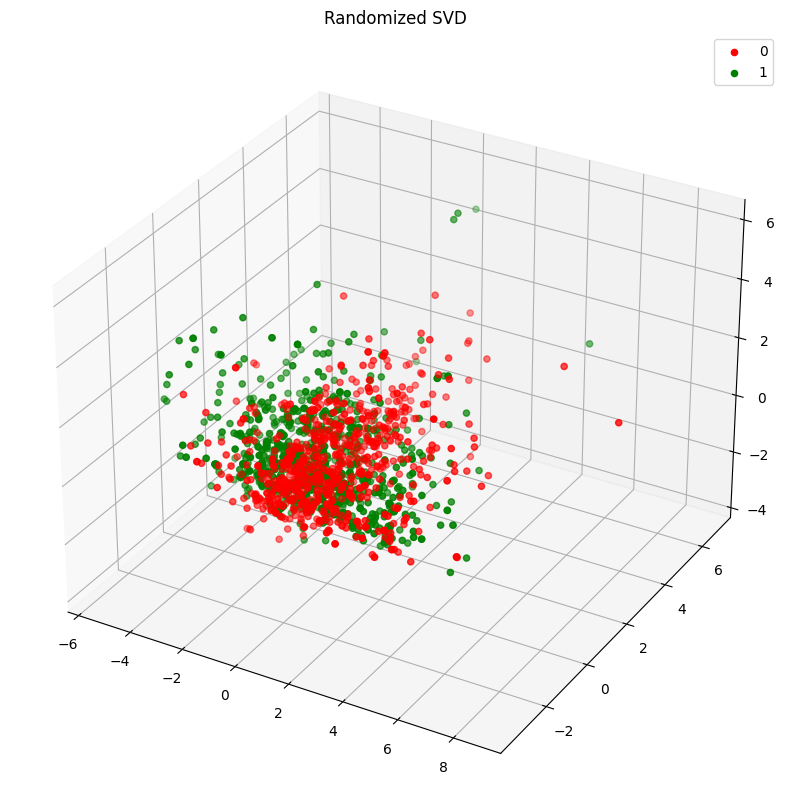

0.7139588246916329 0.05776537476350185


In [16]:
reducer=PCA(n_components=3,svd_solver='randomized')
X_=reducer.fit_transform(X)
f1s[2],stds[2]=estimate(X_,y)
visualize(X_,y,'Randomized SVD')
print(f1s[2],stds[2])
methods.append('Randomized SVD')

## **IncrementalPCA**

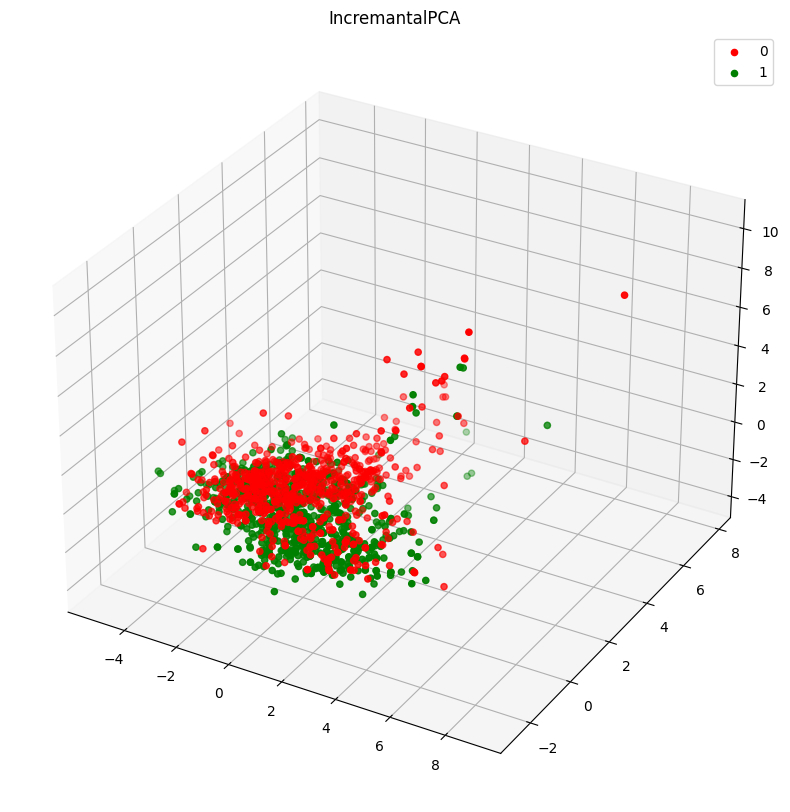

0.6471089699388624 0.0749808233501109


In [17]:
reducer=IncrementalPCA(n_components=3)
X_=reducer.fit_transform(X)
f1s[3],stds[3]=estimate(X_,y)
visualize(X_,y,'IncremantalPCA')
print(f1s[3],stds[3])
methods.append('IncremantalPCA')

## **SparsePCA**

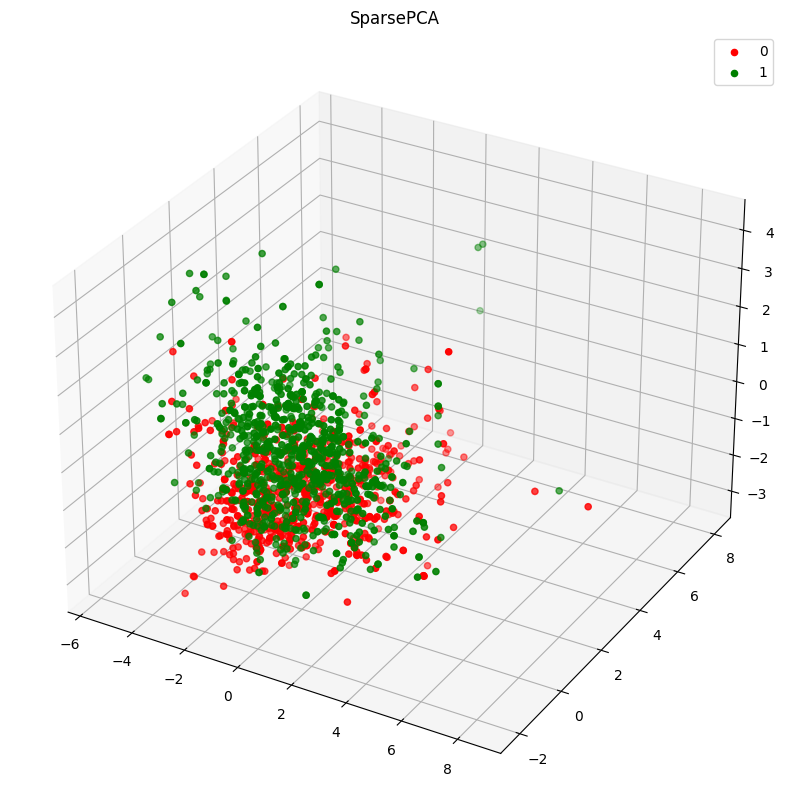

0.7148153636851164 0.0639251598274071


In [18]:
reducer=SparsePCA(n_components=3)
X_=reducer.fit_transform(X)
f1s[4],stds[4]=estimate(X_,y)
visualize(X_,y,'SparsePCA')
print(f1s[4],stds[4])
methods.append('SparsePCA')

## **MiniBatchSparsePCA**

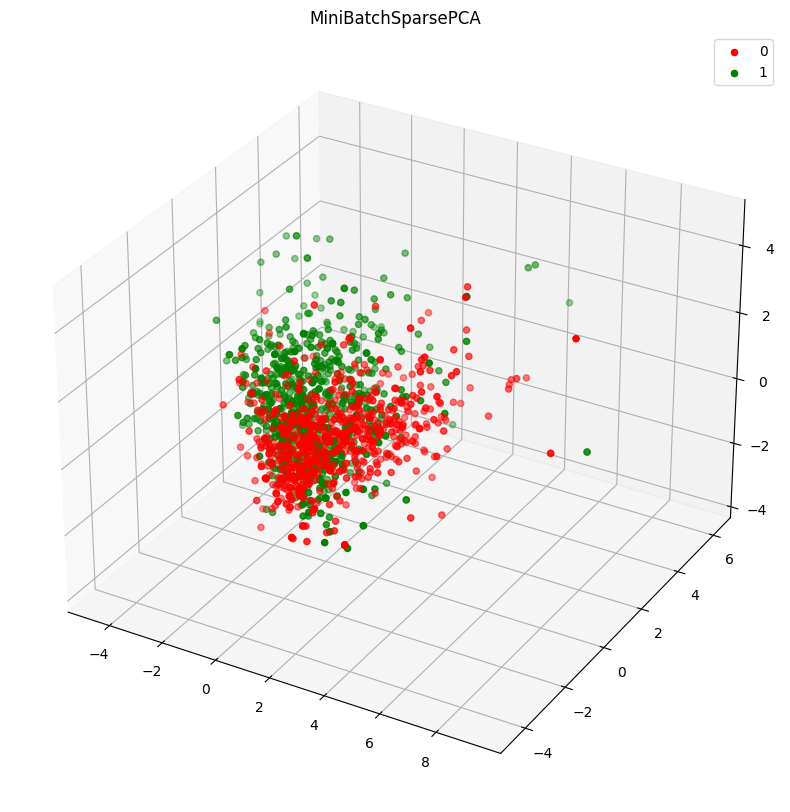

0.7012195757809606 0.05044305546730406


In [19]:
reducer=MiniBatchSparsePCA(n_components=3)
X_=reducer.fit_transform(X)
f1s[5],stds[5]=estimate(X_,y)
visualize(X_,y,'MiniBatchSparsePCA')
print(f1s[5],stds[5])
methods.append('MiniBatchSparsePCA')

## **KernelPCA**

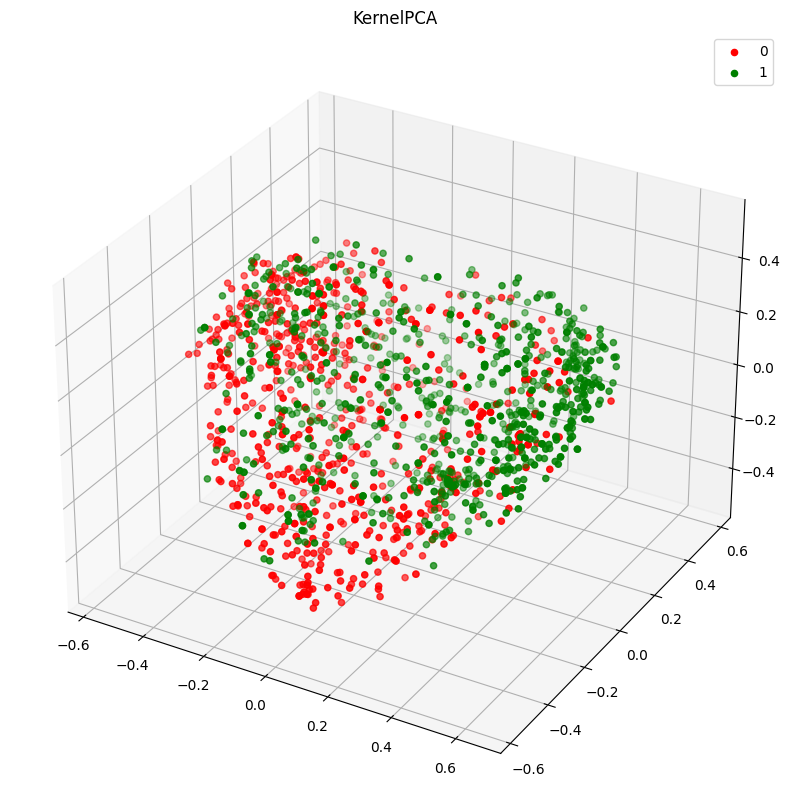

0.7045494308692273 0.04099183254920836


In [20]:
reducer=KernelPCA(n_components=3,kernel='rbf')
X_=reducer.fit_transform(X)
f1s[6],stds[6]=estimate(X_,y)
visualize(X_,y,'KernelPCA')
print(f1s[6],stds[6])
methods.append('KernelPCA')

## **TruncatedSVD**

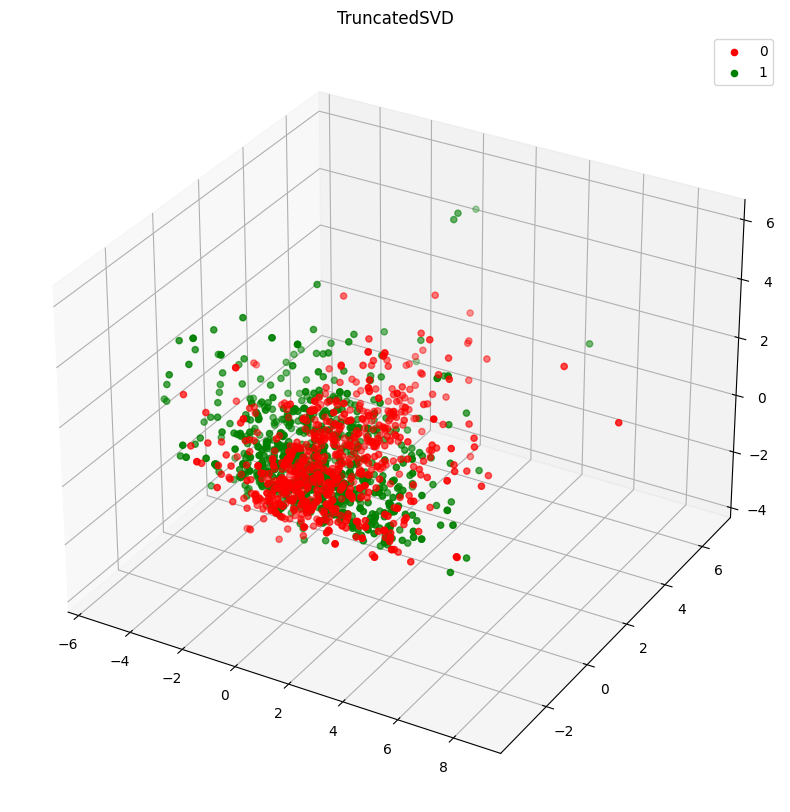

0.6974364784250857 0.06420684304127527


In [21]:
reducer=TruncatedSVD(n_components=3)
X_=reducer.fit_transform(X)
f1s[7],stds[7]=estimate(X_,y)
visualize(X_,y,'TruncatedSVD')
print(f1s[7],stds[7])
methods.append('TruncatedSVD')

## **Dictionary Learning**

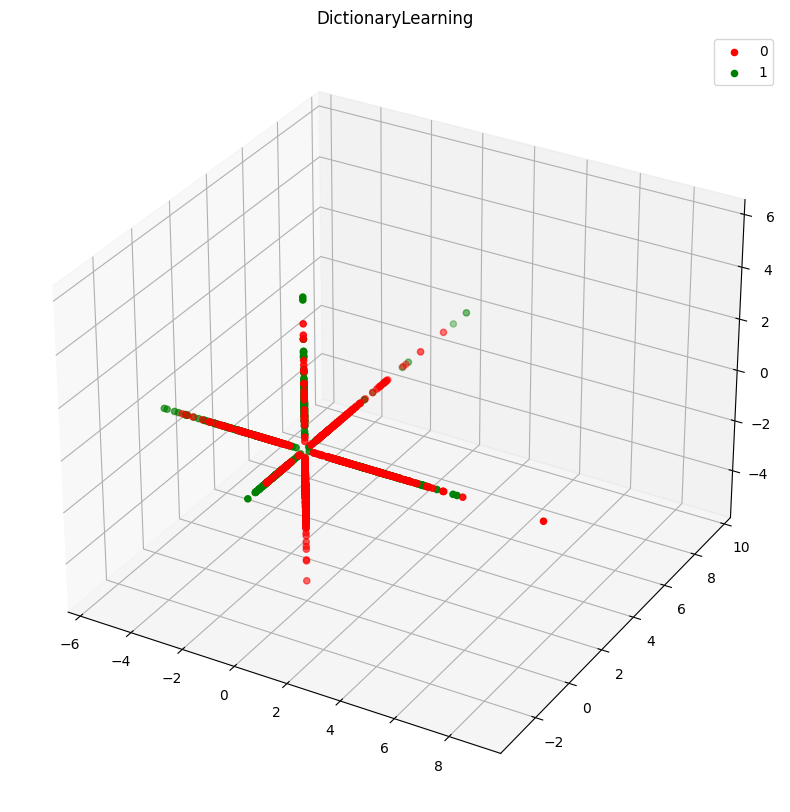

0.715023231186483 0.06957920637882489


In [22]:
reducer=DictionaryLearning(n_components=3)
X_=reducer.fit_transform(X)
f1s[8],stds[8]=estimate(X_,y)
visualize(X_,y,'DictionaryLearning')
print(f1s[8],stds[8])
methods.append('DictionaryLearning')

## **MiniBatchDictionaryLearning**

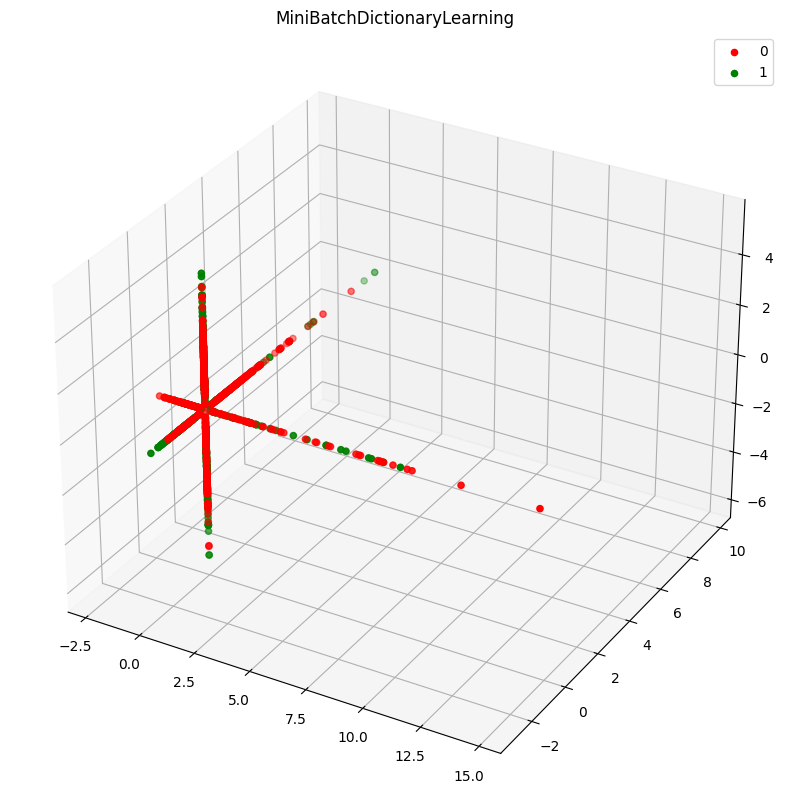

0.7115062727259666 0.021584139387456916


In [23]:
reducer=MiniBatchDictionaryLearning(n_components=3)
X_=reducer.fit_transform(X)
f1s[9],stds[9]=estimate(X_,y)
visualize(X_,y,'MiniBatchDictionaryLearning')
print(f1s[9],stds[9])
methods.append('MiniBatchDictionaryLearning')

## **FactorAnalysis**

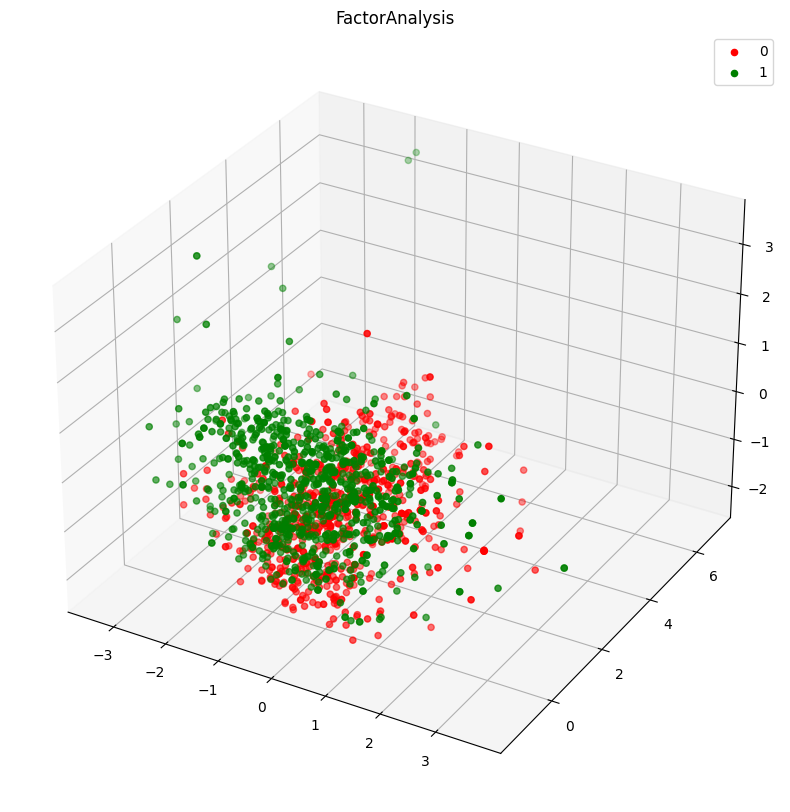

0.6640722122313906 0.08319598613547095


In [24]:
reducer=FactorAnalysis(n_components=3)
X_=reducer.fit_transform(X)
f1s[10],stds[10]=estimate(X_,y)
visualize(X_,y,'FactorAnalysis')
print(f1s[10],stds[10])
methods.append('FactorAnalysis')

## **ICA**

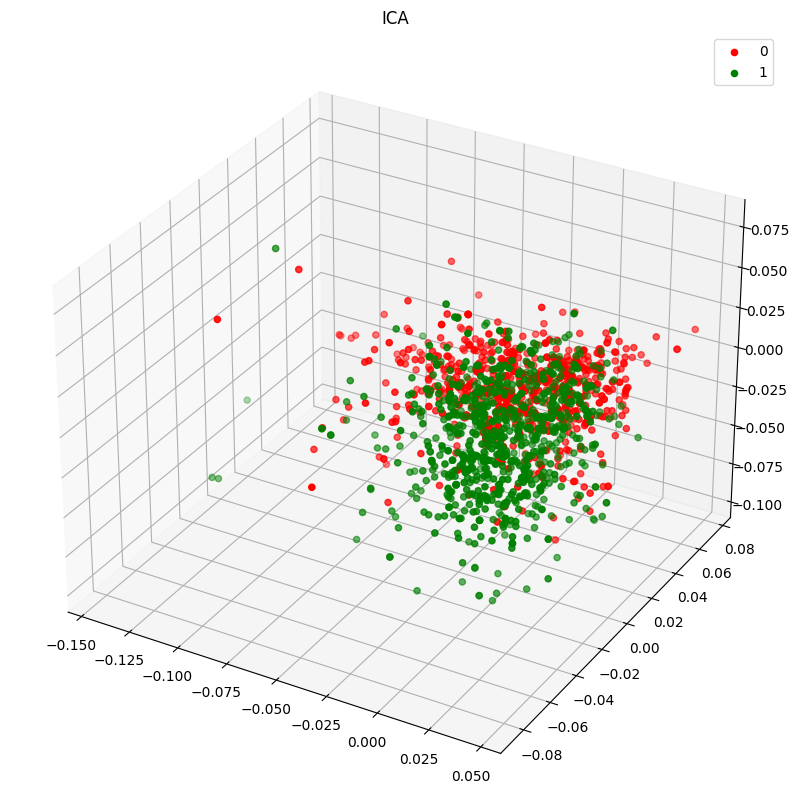

0.7143372713538654 0.060348698132562134


In [25]:
reducer=FastICA(n_components=3)
X_=reducer.fit_transform(X)
f1s[11],stds[11]=estimate(X_,y)
visualize(X_,y,'ICA')
print(f1s[11],stds[11])
methods.append('ICA')

## **NMF**

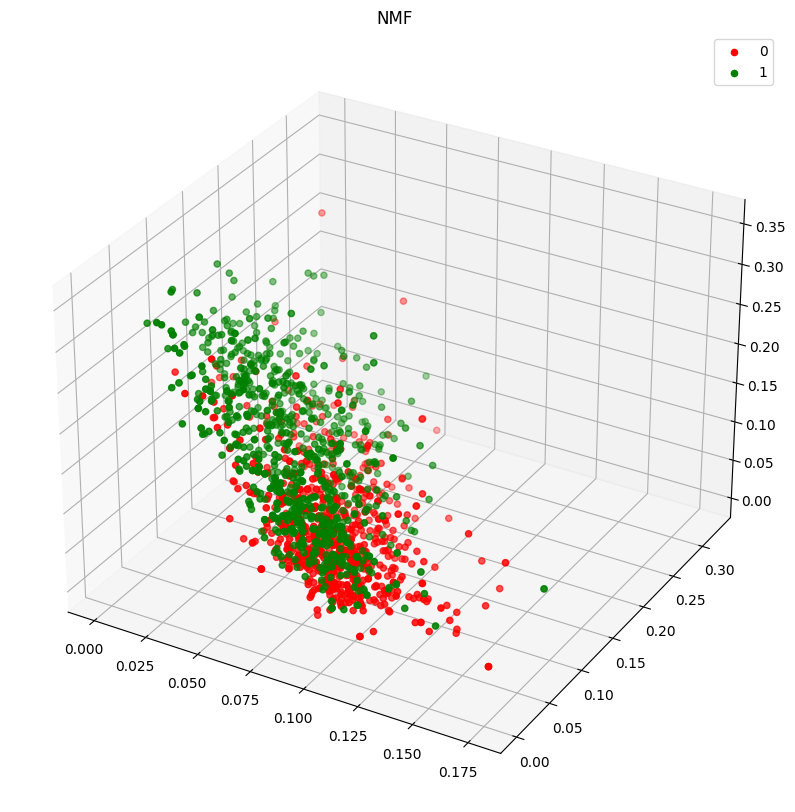

0.6844430088924558 0.08272675190616935


In [26]:
reducer=NMF(n_components=3)
X_=reducer.fit_transform(X__)
f1s[12],stds[12]=estimate(X_,y)
visualize(X_,y,'NMF')
print(f1s[12],stds[12])
methods.append('NMF')

## **LatentDirichletAllocation**

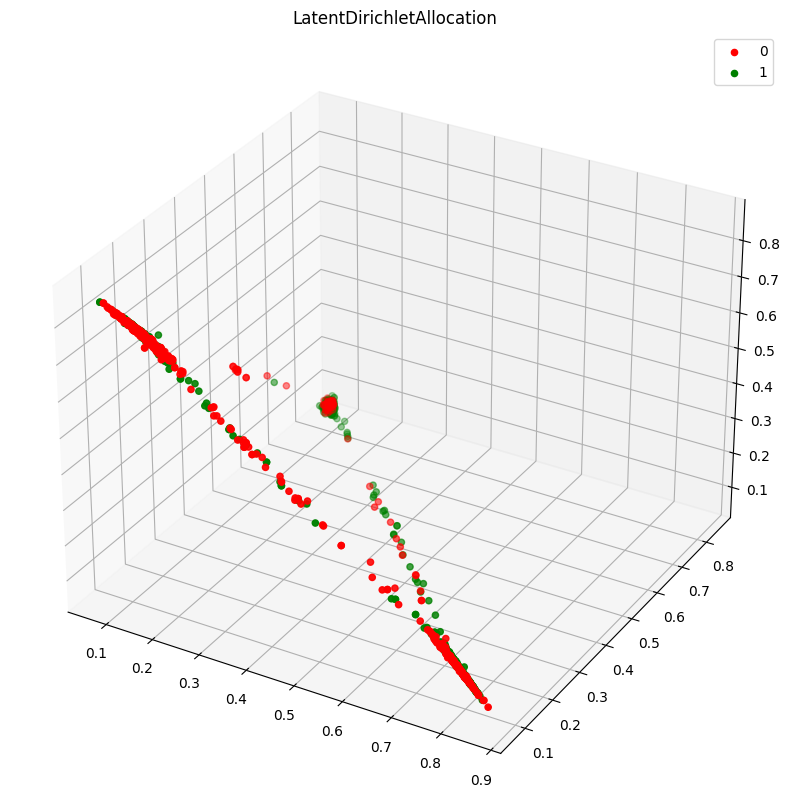

0.6684962462030876 0.040263091787810346


In [27]:
reducer=LatentDirichletAllocation(n_components=3)
X_=reducer.fit_transform(X__)
f1s[13],stds[13]=estimate(X_,y)
visualize(X_,y,'LatentDirichletAllocation')
print(f1s[13],stds[13])
methods.append('LatentDirichletAllocation')

## **LinearDiscriminantAnalysis**

In [28]:
reducer=LinearDiscriminantAnalysis(n_components=1)
X_=reducer.fit(X,y).transform(X)
print(X_)
f1s[14],stds[14]=estimate(X_,y)
print(f1s[14],stds[14])
methods.append('LinearDiscriminantAnalysis')

[[-1.20453488]
 [-1.17863887]
 [-1.01218481]
 ...
 [ 0.9280297 ]
 [-0.10606862]
 [ 0.75807917]]
0.7403483237746287 0.04984834712188142


## **AutoEncoder with linear activations**

Model: "linear_auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - loss: 1.0664

I0000 00:00:1713337848.948965     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713337848.965233     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 1.1112
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0697 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9804 
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9442 
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9203 
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9097 
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8296 
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8368 
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8179 
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7826 
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7538 
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7051 
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6910 
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6350 
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6365 
Epoch 16/50
13/

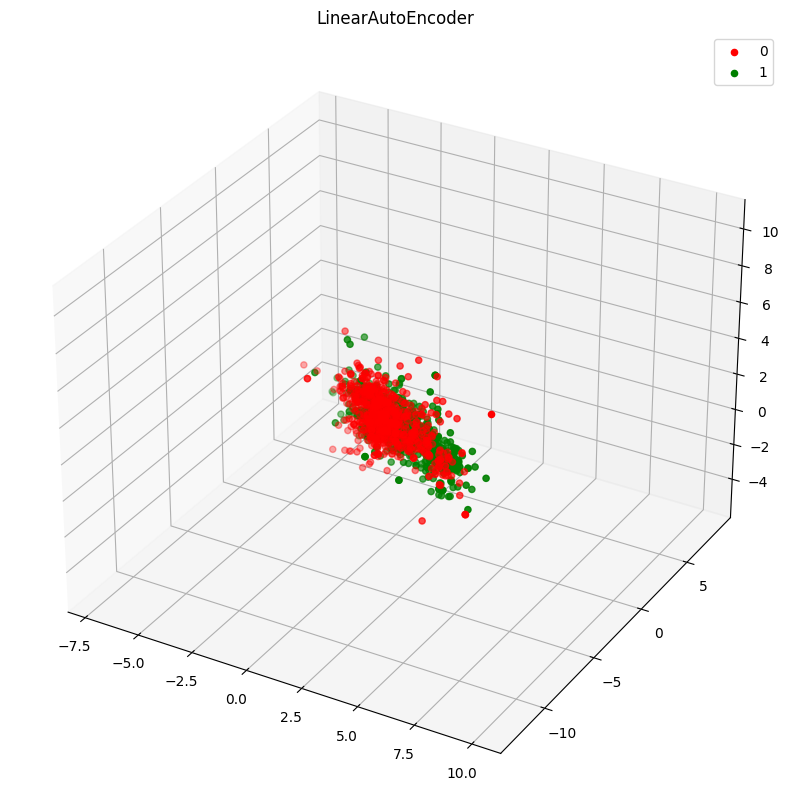

0.6739069202250304 0.024612301094859623


In [29]:
model=LinearAutoEncoder(input_dim=X.shape[1])
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError())
model.summary()
hist=model.fit(X,X,epochs=50,batch_size=128)
reducer=model.encoder
X_=reducer(X).numpy()
f1s[15],stds[15]=estimate(X_,y)
visualize(X_,y,'LinearAutoEncoder')
print(f1s[15],stds[15])
methods.append('LinearAutoEncoder')

## **AutoEncoder with non-linear activations**

Model: "non_linear_auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.1874

W0000 00:00:1713337855.495625     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 1.4100
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2657 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1556 
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0683 
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0139 
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9885 
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9577 
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9102 
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9154 
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9516 
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8500 
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8354 
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8561 
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8489 
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8532 
Epoch 16/50
13/

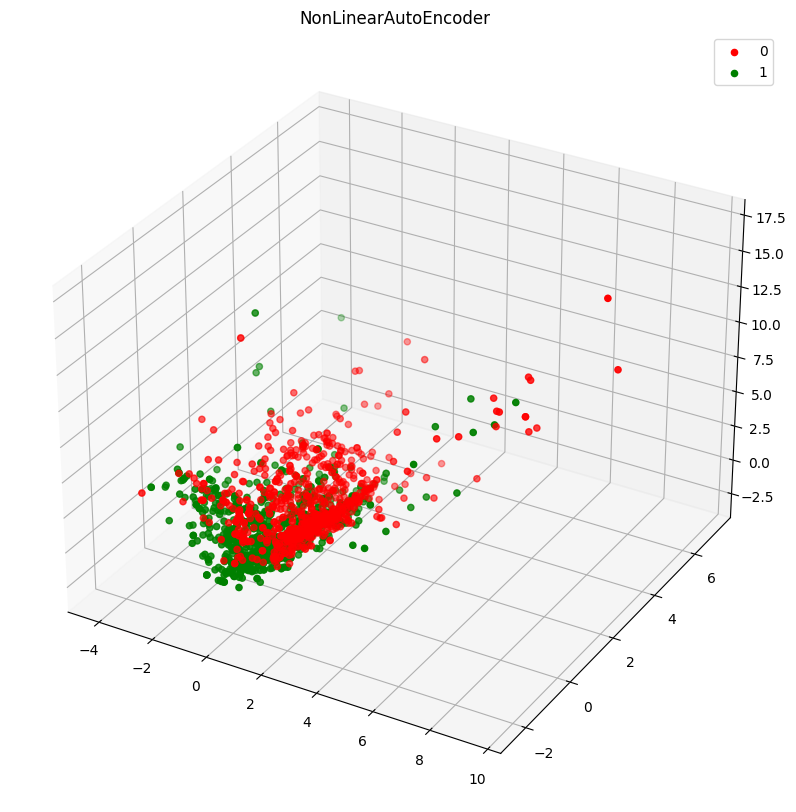

0.6733001946161734 0.051735574287136606


In [30]:
model=NonLinearAutoEncoder(input_dim=X.shape[1])
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError())
model.summary()
hist=model.fit(X,X,epochs=50,batch_size=128)
reducer=model.encoder
X_=reducer(X).numpy()
f1s[16],stds[16]=estimate(X_,y)
visualize(X_,y,'NonLinearAutoEncoder')
print(f1s[16],stds[16])
methods.append('NonLinearAutoEncoder')

## **Visualizing overall perfomance across methods**

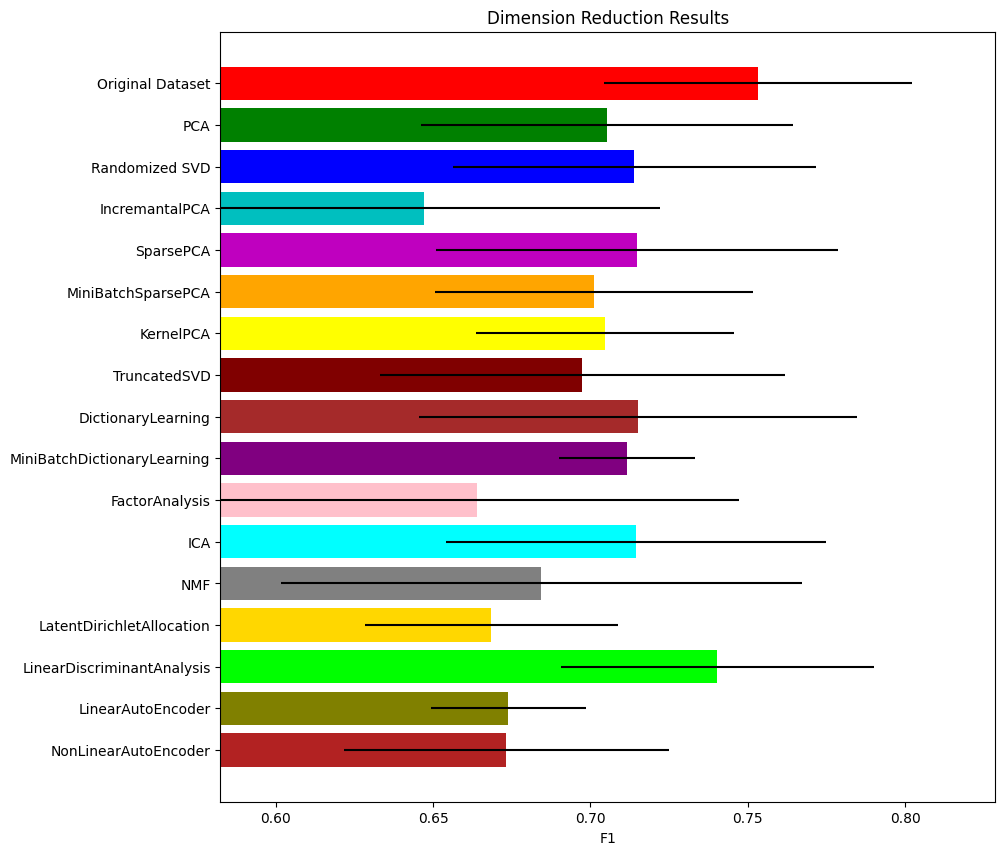

In [31]:
n_bars=len(f1s)
colors=["r", "g", "b", "c", "m",'orange','yellow','maroon','brown','purple','pink','aqua','gray','gold','lime','olive','firebrick']
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
for j in range(n_bars):
    ax.barh(j,f1s[j],xerr=stds[j],color=colors[j],align="center")
ax.set_title("Dimension Reduction Results")
ax.set_xlim(left=np.min(f1s)* 0.9,right=np.max(f1s)*1.1)
ax.set_yticks(range(n_bars))
ax.set_xlabel("F1")
ax.invert_yaxis()
x_labels=methods
ax.set_yticklabels(x_labels)
plt.show()

# **Second dataset**

In [32]:
methods=[]
f1s=np.zeros(shape=17)
stds=np.zeros(shape=17)

In [33]:
X,y=make_classification(n_samples=101,n_features=16,n_informative=3,n_redundant=3)
print(X)
print(y)

[[-0.61597297  0.35375187  2.49187431 ...  0.40074036 -0.48629408
  -0.89978454]
 [-0.42342093 -0.11238124  0.41469027 ...  1.33030475 -0.78713081
  -0.94020787]
 [ 0.13134003  0.22289901 -0.20813259 ...  1.0952035  -0.67900392
   1.42054507]
 ...
 [-0.12796956 -0.76621538 -0.38833791 ... -0.02813239 -0.62927033
  -0.72014095]
 [ 0.54696798  0.26923827 -0.50516212 ...  0.46376822 -0.06543369
  -0.54598737]
 [-0.40908205  0.64474276  0.09877095 ...  0.04444265 -0.64402918
  -0.69261685]]
[1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1
 1 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1
 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0]


In [34]:
X__=X.copy()
for i in range(X.shape[1]):
    X[:,i]=StandardScaler().fit_transform(X[:,i].reshape(-1,1))[:,0]
for i in range(X.shape[1]):
    X__[:,i]=MinMaxScaler().fit_transform(X[:,i].reshape(-1,1))[:,0]

## **Original dataset**

In [35]:
f1s[0],stds[0]=estimate(X,y)
methods.append('Original Dataset')
print(f1s[0],stds[0])

0.774947428246661 0.04310823492274641


## **PCA**

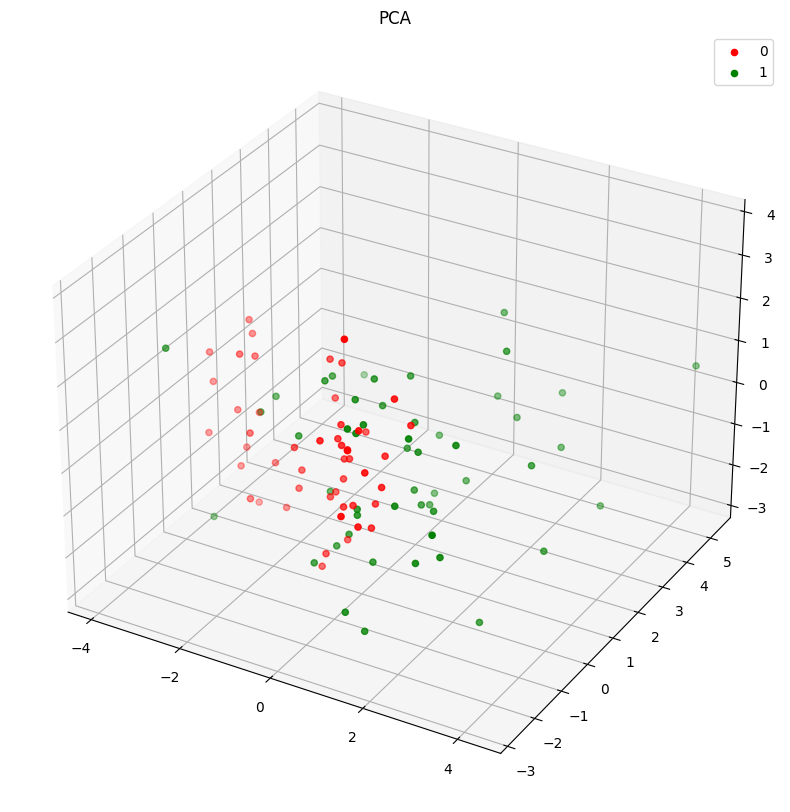

0.7829239766081871 0.067859846674886


In [36]:
reducer=PCA(n_components=3)
X_=reducer.fit_transform(X)
f1s[1],stds[1]=estimate(X_,y)
visualize(X_,y,'PCA')
print(f1s[1],stds[1])
methods.append('PCA')

## **Randomized SVD**

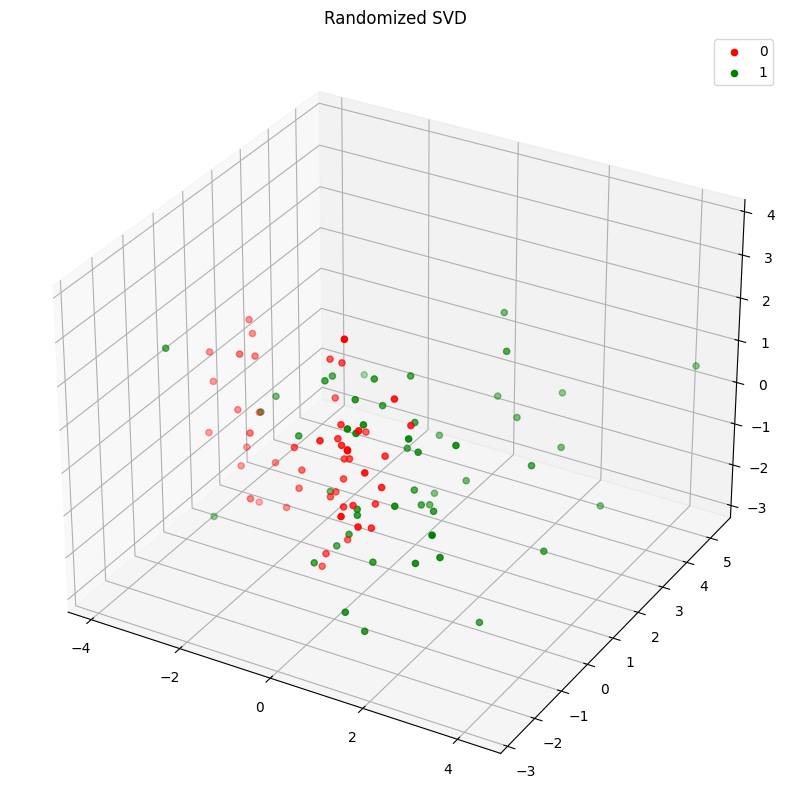

0.7268782249742001 0.09435662034922479


In [37]:
reducer=PCA(n_components=3,svd_solver='randomized')
X_=reducer.fit_transform(X)
f1s[2],stds[2]=estimate(X_,y)
visualize(X_,y,'Randomized SVD')
print(f1s[2],stds[2])
methods.append('Randomized SVD')

## **IncrementalPCA**

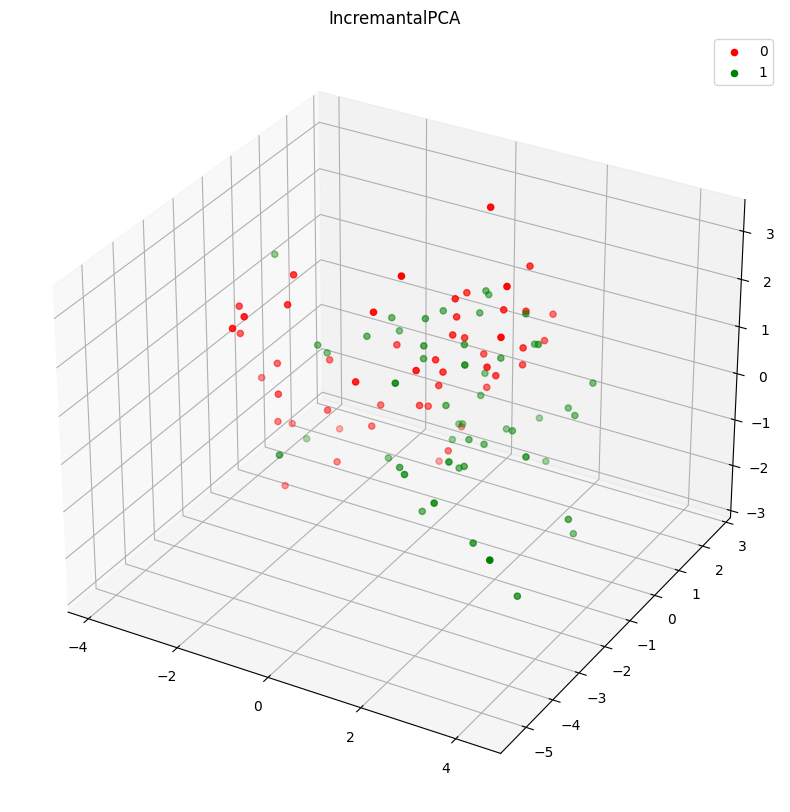

0.7519504643962847 0.09432403637488584


In [38]:
reducer=IncrementalPCA(n_components=3)
X_=reducer.fit_transform(X)
f1s[3],stds[3]=estimate(X_,y)
visualize(X_,y,'IncremantalPCA')
print(f1s[3],stds[3])
methods.append('IncremantalPCA')

## **SparsePCA**

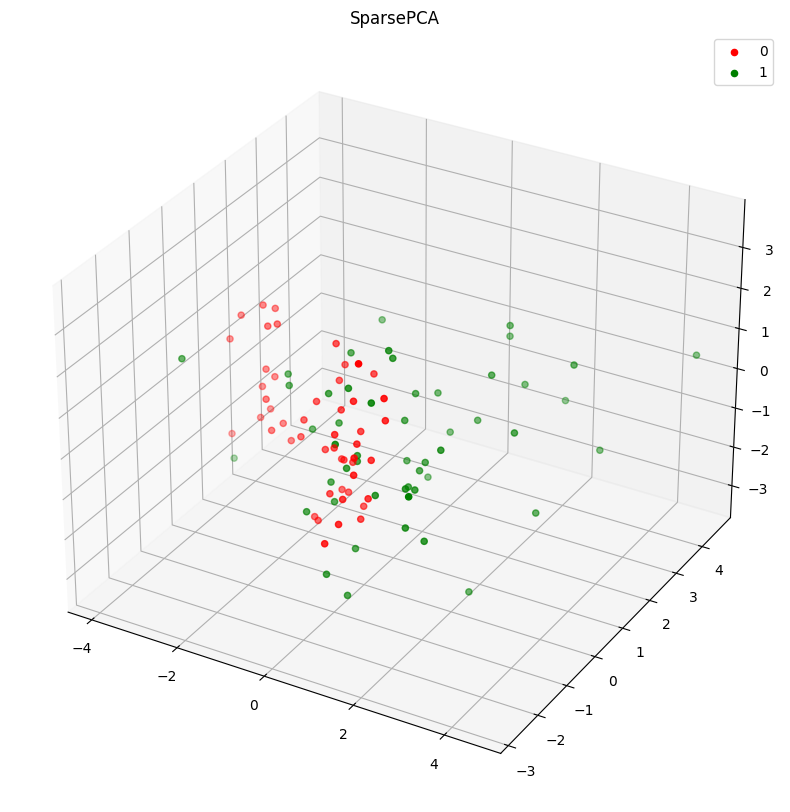

0.6775271512113618 0.12258346658974117


In [39]:
reducer=SparsePCA(n_components=3)
X_=reducer.fit_transform(X)
f1s[4],stds[4]=estimate(X_,y)
visualize(X_,y,'SparsePCA')
print(f1s[4],stds[4])
methods.append('SparsePCA')

## **MiniBatchSparsePCA**

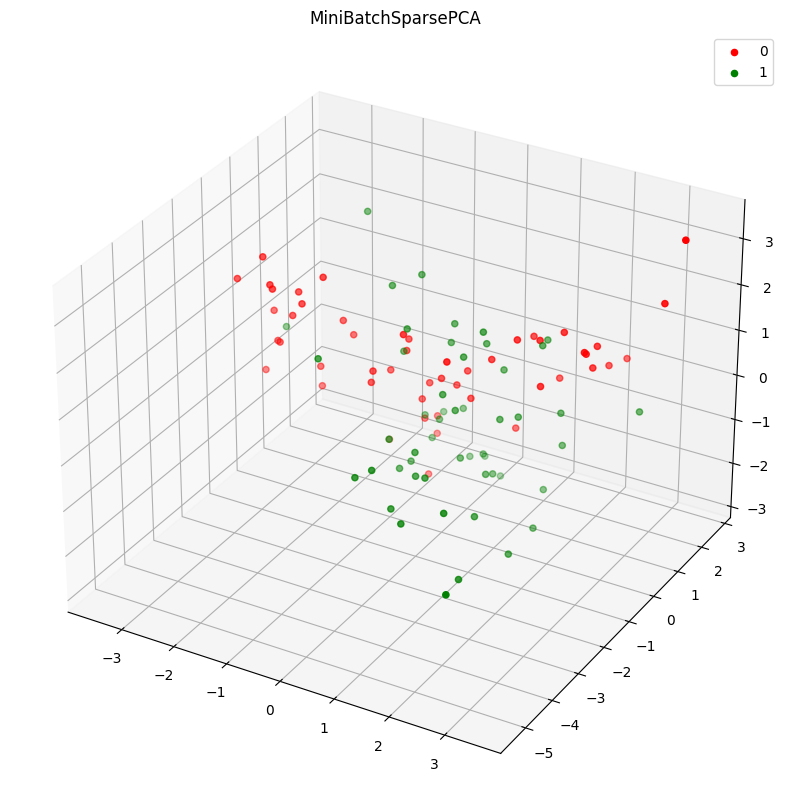

0.7018056504898611 0.1168989054458901


In [40]:
reducer=MiniBatchSparsePCA(n_components=3)
X_=reducer.fit_transform(X)
f1s[5],stds[5]=estimate(X_,y)
visualize(X_,y,'MiniBatchSparsePCA')
print(f1s[5],stds[5])
methods.append('MiniBatchSparsePCA')

## **KernelPCA**

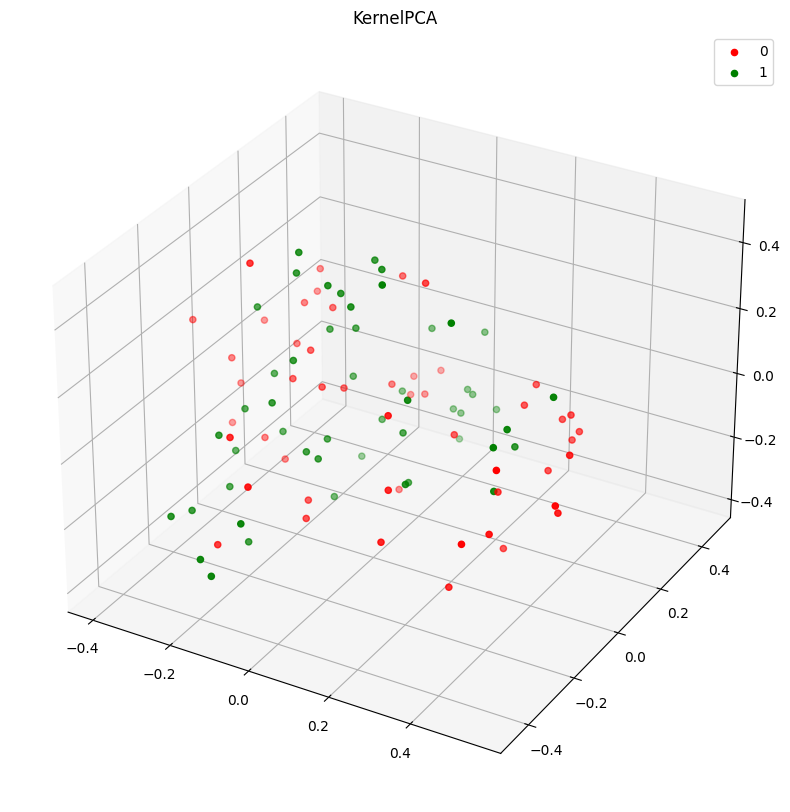

0.6677958840887901 0.10613001004805858


In [41]:
reducer=KernelPCA(n_components=3,kernel='rbf')
X_=reducer.fit_transform(X)
f1s[6],stds[6]=estimate(X_,y)
visualize(X_,y,'KernelPCA')
print(f1s[6],stds[6])
methods.append('KernelPCA')

## **TruncatedSVD**

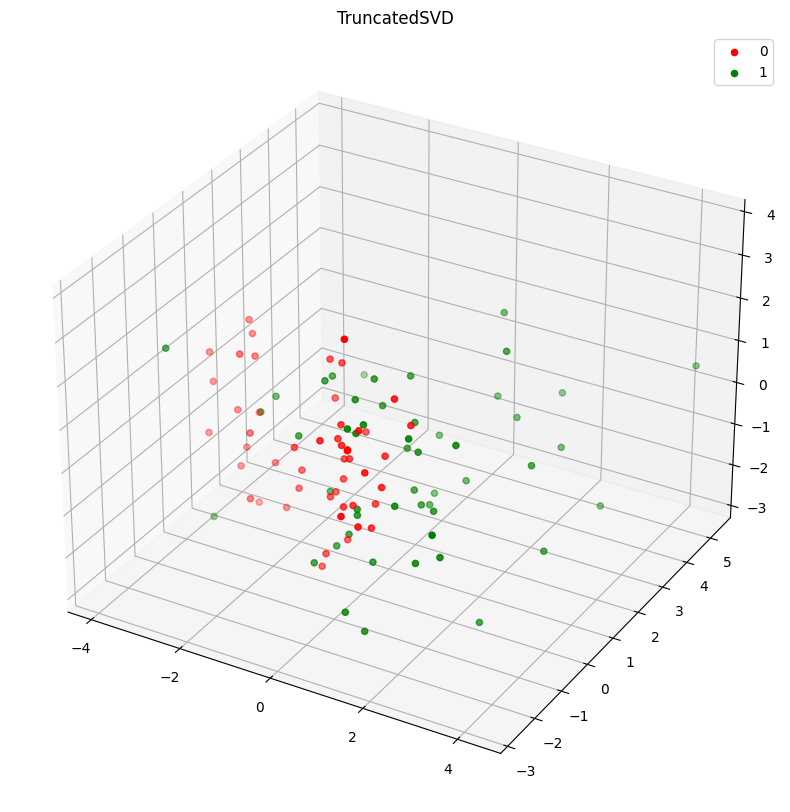

0.7773099415204678 0.08656819780363258


In [42]:
reducer=TruncatedSVD(n_components=3)
X_=reducer.fit_transform(X)
f1s[7],stds[7]=estimate(X_,y)
visualize(X_,y,'TruncatedSVD')
print(f1s[7],stds[7])
methods.append('TruncatedSVD')

## **Dictionary Learning**

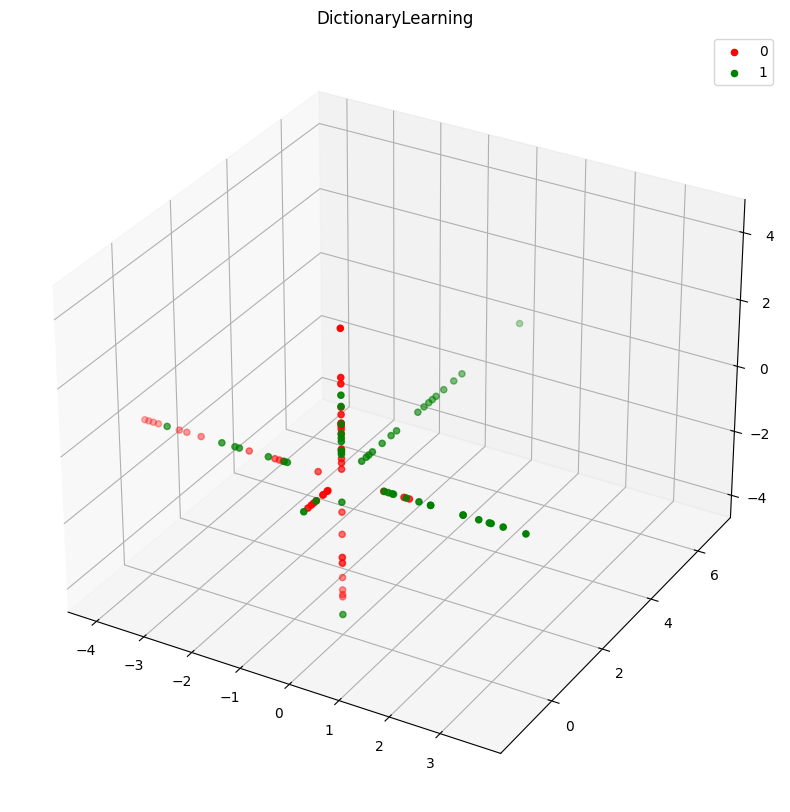

0.7012641898864809 0.07492361341416459


In [43]:
reducer=DictionaryLearning(n_components=3)
X_=reducer.fit_transform(X)
f1s[8],stds[8]=estimate(X_,y)
visualize(X_,y,'DictionaryLearning')
print(f1s[8],stds[8])
methods.append('DictionaryLearning')

## **MiniBatchDictionaryLearning**

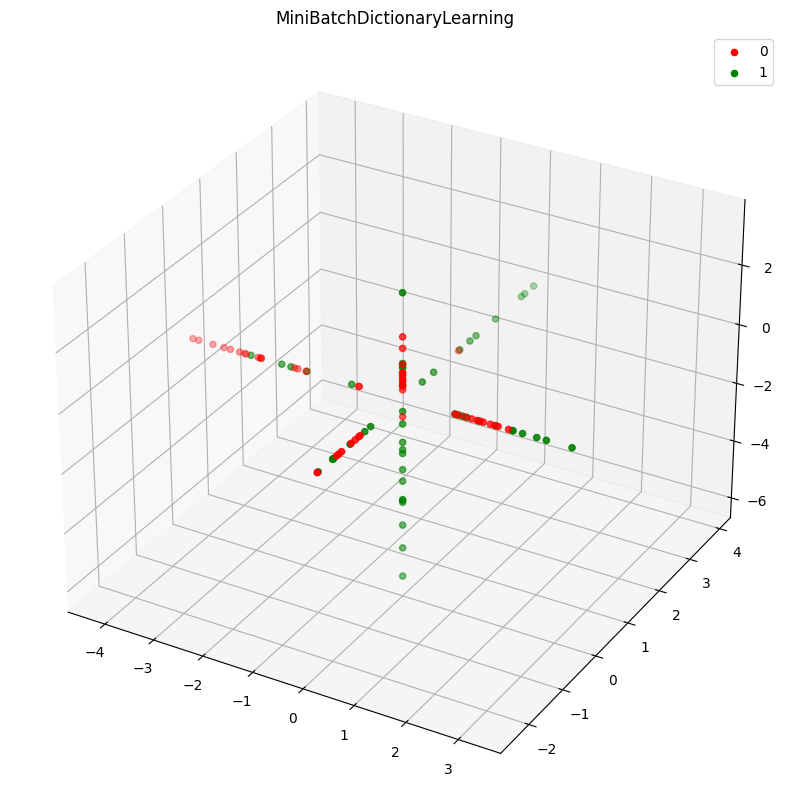

0.6166214177978884 0.08581088180232557


In [44]:
reducer=MiniBatchDictionaryLearning(n_components=3)
X_=reducer.fit_transform(X)
f1s[9],stds[9]=estimate(X_,y)
visualize(X_,y,'MiniBatchDictionaryLearning')
print(f1s[9],stds[9])
methods.append('MiniBatchDictionaryLearning')

## **FactorAnalysis**

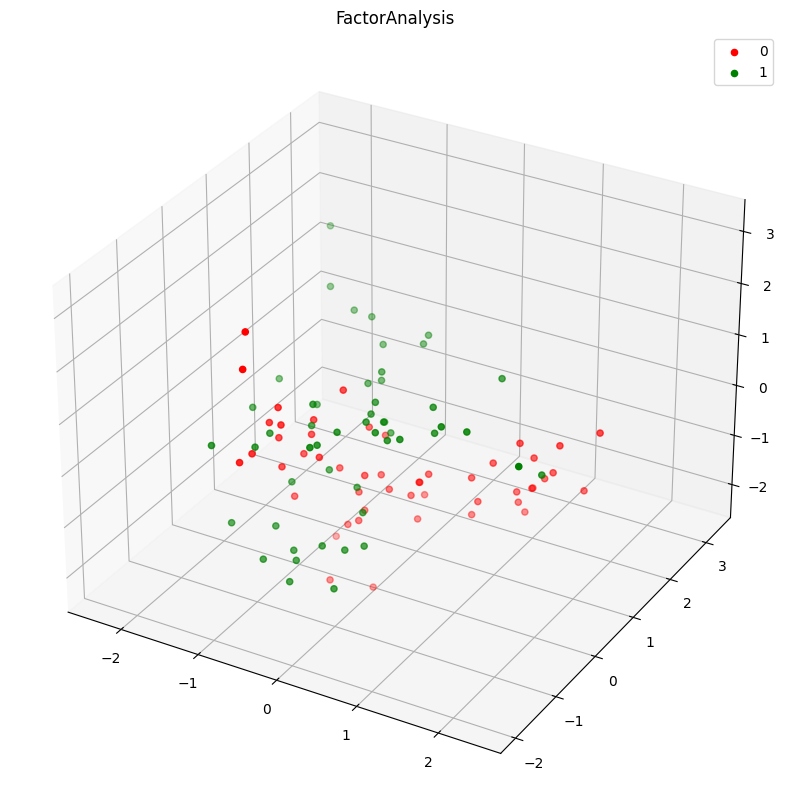

0.7638901601830663 0.02354474241305574


In [45]:
reducer=FactorAnalysis(n_components=3)
X_=reducer.fit_transform(X)
f1s[10],stds[10]=estimate(X_,y)
visualize(X_,y,'FactorAnalysis')
print(f1s[10],stds[10])
methods.append('FactorAnalysis')

## **ICA**

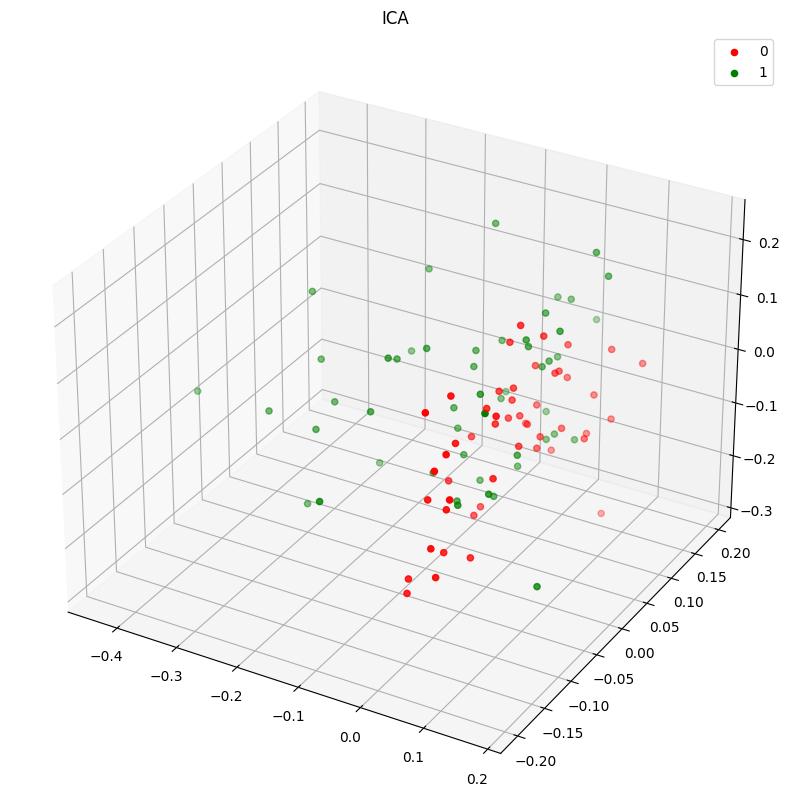

0.6786096256684491 0.10751722234748398


In [46]:
reducer=FastICA(n_components=3)
X_=reducer.fit_transform(X)
f1s[11],stds[11]=estimate(X_,y)
visualize(X_,y,'ICA')
print(f1s[11],stds[11])
methods.append('ICA')

## **NMF**

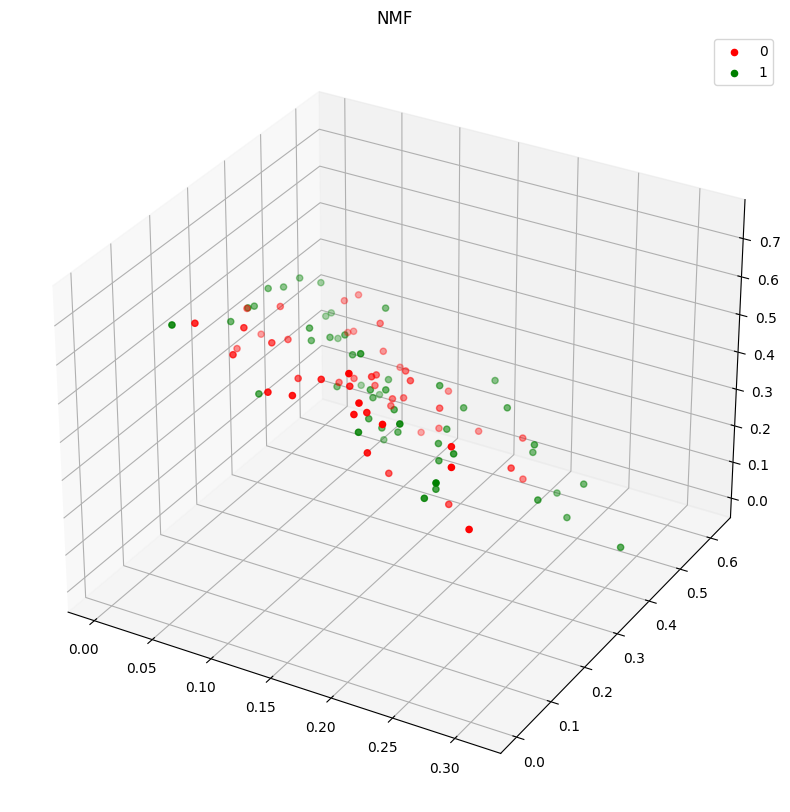

0.6558403914925653 0.09142709592971142


In [47]:
reducer=NMF(n_components=3)
X_=reducer.fit_transform(X__)
f1s[12],stds[12]=estimate(X_,y)
visualize(X_,y,'NMF')
print(f1s[12],stds[12])
methods.append('NMF')

## **LatentDirichletAllocation**

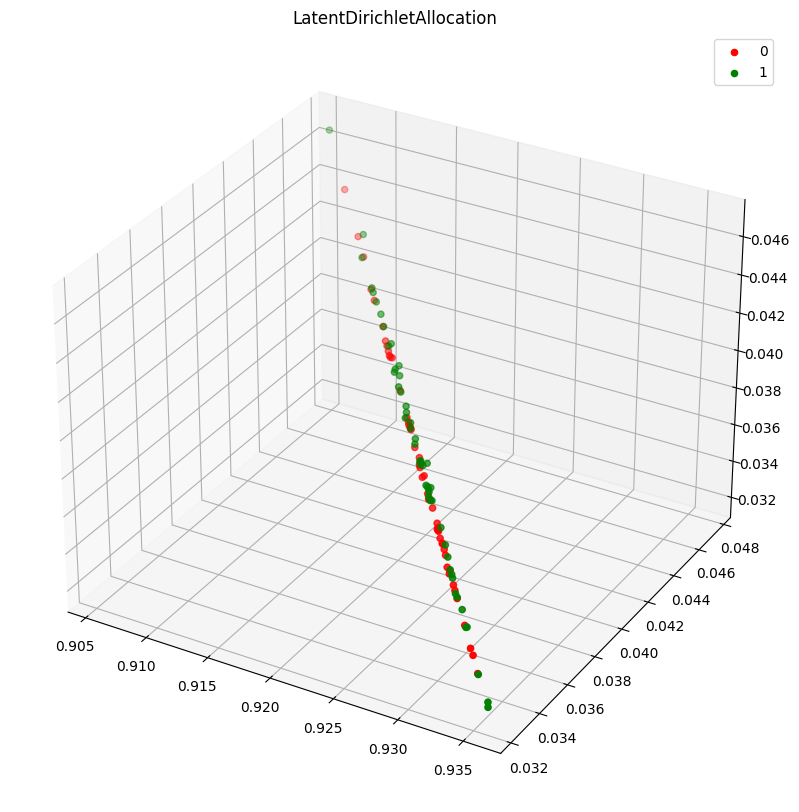

0.5862525879917184 0.07667789002744753


In [48]:
reducer=LatentDirichletAllocation(n_components=3)
X_=reducer.fit_transform(X__)
f1s[13],stds[13]=estimate(X_,y)
visualize(X_,y,'LatentDirichletAllocation')
print(f1s[13],stds[13])
methods.append('LatentDirichletAllocation')

## **LinearDiscriminantAnalysis**

In [49]:
reducer=LinearDiscriminantAnalysis(n_components=1)
X_=reducer.fit(X,y).transform(X)
print(X_)
f1s[14],stds[14]=estimate(X_,y)
print(f1s[14],stds[14])
methods.append('LinearDiscriminantAnalysis')

[[ 4.37733700e+00]
 [ 8.90957830e-01]
 [-1.36253604e+00]
 [-5.99420681e-01]
 [-1.06253676e+00]
 [ 2.02518029e+00]
 [ 1.17223975e+00]
 [-1.51149133e-01]
 [-9.59795019e-01]
 [ 5.93410317e-01]
 [-2.61215959e+00]
 [-1.33795869e-01]
 [-3.34708684e-03]
 [ 2.19124352e-01]
 [-1.98344735e+00]
 [ 1.16160064e+00]
 [-4.81592230e-01]
 [ 4.43627043e-01]
 [-1.09563040e+00]
 [ 1.54349756e+00]
 [ 2.98150828e+00]
 [ 9.21218412e-01]
 [-2.19811667e+00]
 [ 1.71238813e-01]
 [ 5.32356878e-01]
 [ 6.61961681e-01]
 [ 1.23158187e+00]
 [ 1.01786402e+00]
 [-1.12590923e+00]
 [ 3.77245718e-01]
 [-8.58624583e-01]
 [ 3.66373086e-01]
 [ 2.16015622e-01]
 [-7.72294770e-01]
 [ 2.41898928e+00]
 [ 7.23240923e-01]
 [ 8.55128990e-01]
 [ 2.56484845e-01]
 [-3.03447709e-02]
 [ 2.13710168e+00]
 [-1.02012910e+00]
 [-3.88278823e-01]
 [ 3.07539379e+00]
 [ 1.09538540e+00]
 [-5.67041302e-02]
 [-1.13134847e+00]
 [-1.16131962e+00]
 [ 1.86041194e-04]
 [ 1.01650193e+00]
 [-6.82371246e-01]
 [ 5.06361852e-02]
 [-3.03573646e-01]
 [-8.8362537

## **AutoEncoder with linear activations**

Model: "linear_auto_encoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3753
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3681
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3614
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3551
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3492
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3437
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3386
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3339
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3294
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3253
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3214
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3178
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3145
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3113
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3083
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

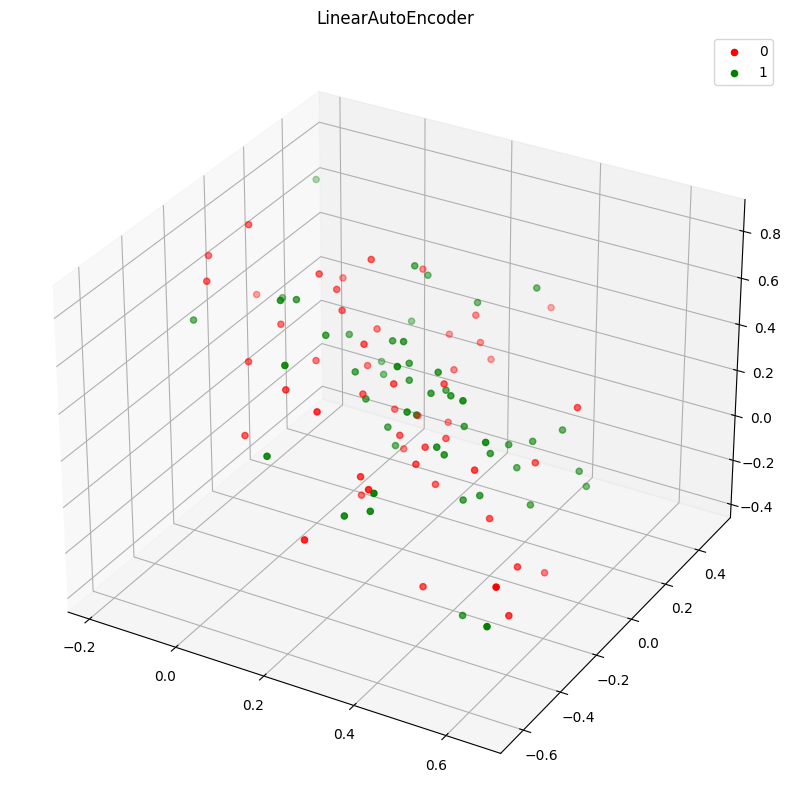

0.5008987943003287 0.10357710640488897


In [50]:
model=LinearAutoEncoder(input_dim=X.shape[1])
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError())
model.summary()
hist=model.fit(X__,X__,epochs=50,batch_size=128)
reducer=model.encoder
X_=reducer(X__).numpy()
f1s[15],stds[15]=estimate(X_,y)
visualize(X_,y,'LinearAutoEncoder')
print(f1s[15],stds[15])
methods.append('LinearAutoEncoder')

## **AutoEncoder with non-linear activations**

Model: "non_linear_auto_encoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5902
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5721
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5548
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5381
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5221
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5067
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4920
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4780
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4646
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4518
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4397
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4282
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4171
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4065
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3965
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

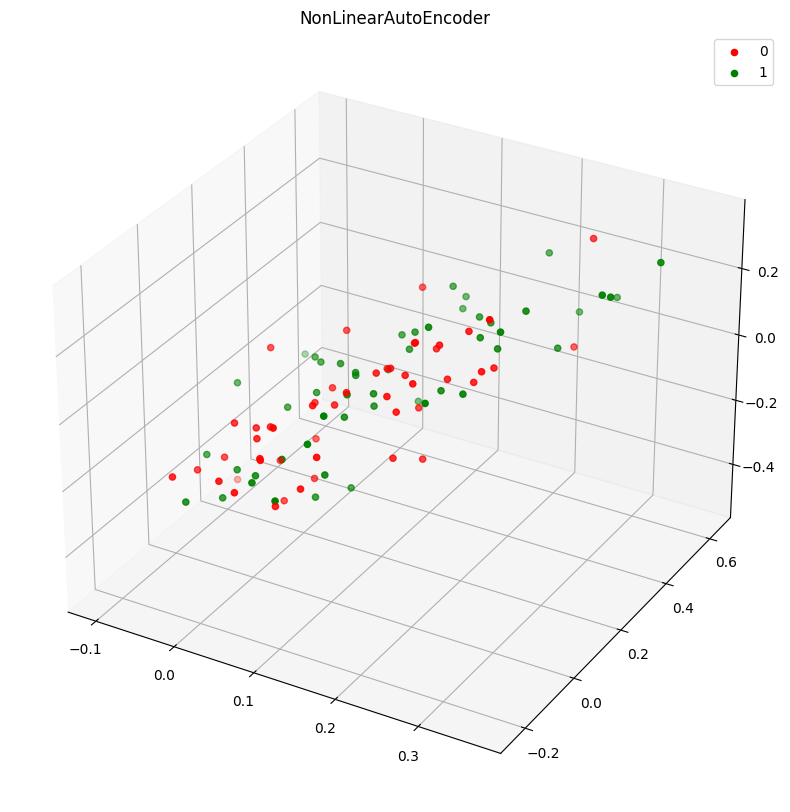

0.5229102167182662 0.11082342108851974


In [51]:
model=NonLinearAutoEncoder(input_dim=X.shape[1])
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError())
model.summary()
hist=model.fit(X__,X__,epochs=50,batch_size=128)
reducer=model.encoder
X_=reducer(X__).numpy()
f1s[16],stds[16]=estimate(X_,y)
visualize(X_,y,'NonLinearAutoEncoder')
print(f1s[16],stds[16])
methods.append('NonLinearAutoEncoder')

## **Visualizing overall perfomance across methods**

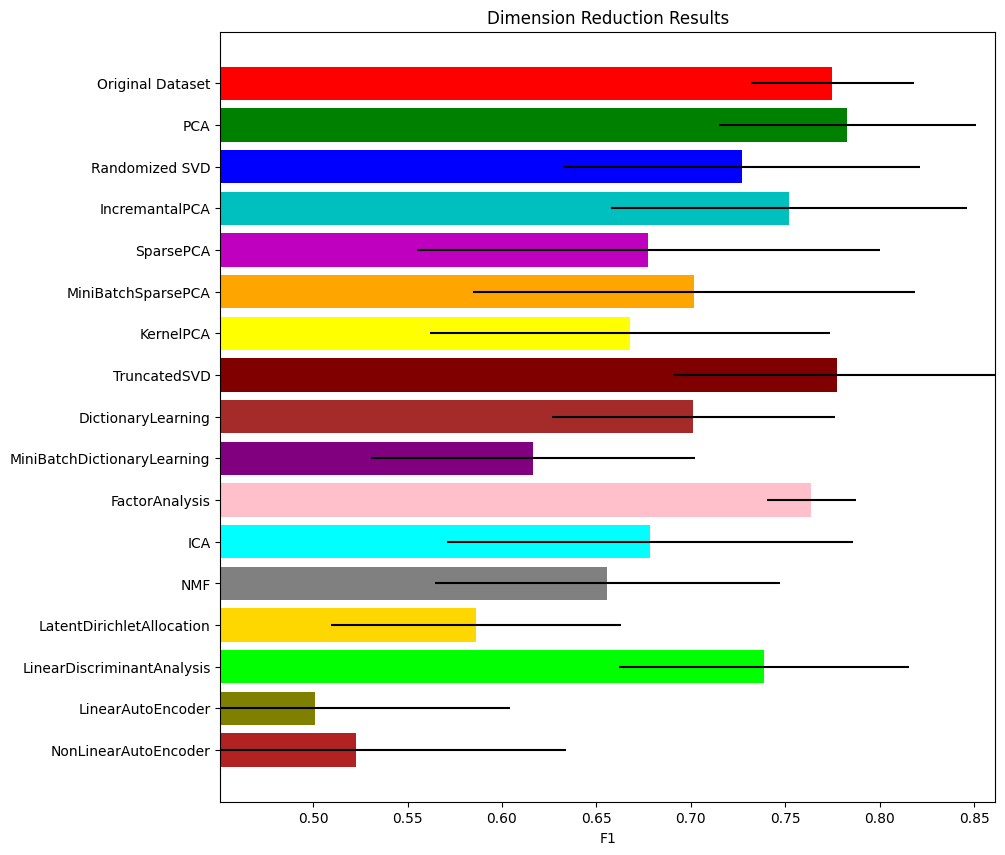

In [52]:
n_bars=len(f1s)
colors=["r", "g", "b", "c", "m",'orange','yellow','maroon','brown','purple','pink','aqua','gray','gold','lime','olive','firebrick']
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
for j in range(n_bars):
    ax.barh(j,f1s[j],xerr=stds[j],color=colors[j],align="center")
ax.set_title("Dimension Reduction Results")
ax.set_xlim(left=np.min(f1s)* 0.9,right=np.max(f1s)*1.1)
ax.set_yticks(range(n_bars))
ax.set_xlabel("F1")
ax.invert_yaxis()
x_labels=methods
ax.set_yticklabels(x_labels)
plt.show()

# **Third dataset**

In [53]:
methods=[]
f1s=np.zeros(shape=17)
stds=np.zeros(shape=17)

In [54]:
X,y=make_classification(n_samples=101,n_features=102,n_informative=3,n_redundant=3)
print(X)
print(y)

[[ 3.44277084e-01 -5.45624354e-01 -1.11438575e+00 ... -1.25163612e+00
   2.22463936e-01 -7.71016228e-01]
 [-1.33867486e-01  1.03924919e+00 -6.11405176e-01 ...  8.16518127e-01
  -9.88575815e-02  9.12556558e-02]
 [-1.62069351e-03  1.17561128e+00  4.58704219e-01 ... -2.29540554e-01
  -1.23168934e-01 -6.62193447e-01]
 ...
 [-1.42290617e+00  1.47714542e+00 -2.44238771e-01 ...  6.00516122e-01
   9.24275504e-02 -7.98591814e-01]
 [ 1.64981224e+00 -2.70204013e-03 -1.73667202e+00 ... -2.40497659e+00
  -1.84284951e+00  5.55435206e-01]
 [ 2.54629282e-01 -1.73203139e-01  3.19577031e-01 ... -5.56322457e-01
  -9.27849368e-01  1.95935401e+00]]
[0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1
 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1
 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1]


In [55]:
X__=X.copy()
for i in range(X.shape[1]):
    X[:,i]=StandardScaler().fit_transform(X[:,i].reshape(-1,1))[:,0]
for i in range(X.shape[1]):
    X__[:,i]=MinMaxScaler().fit_transform(X[:,i].reshape(-1,1))[:,0]

## **Original dataset**

In [56]:
f1s[0],stds[0]=estimate(X,y)
methods.append('Original Dataset')
print(f1s[0],stds[0])

0.5984370015948963 0.11968943700152333


## **PCA**

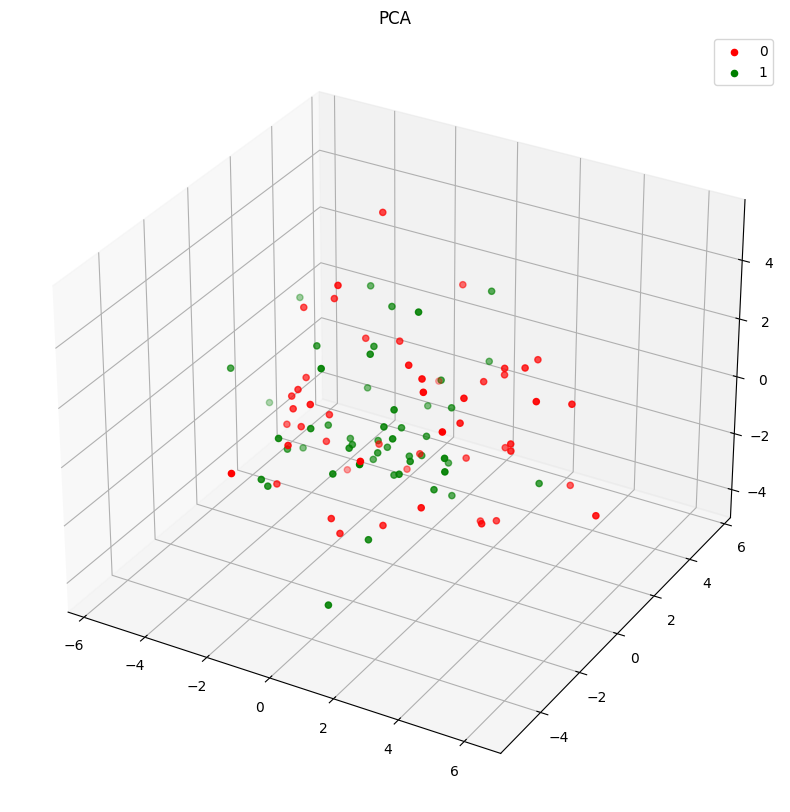

0.6067494824016563 0.06954470761444966


In [57]:
reducer=PCA(n_components=3)
X_=reducer.fit_transform(X)
f1s[1],stds[1]=estimate(X_,y)
visualize(X_,y,'PCA')
print(f1s[1],stds[1])
methods.append('PCA')

## **Randomized SVD**

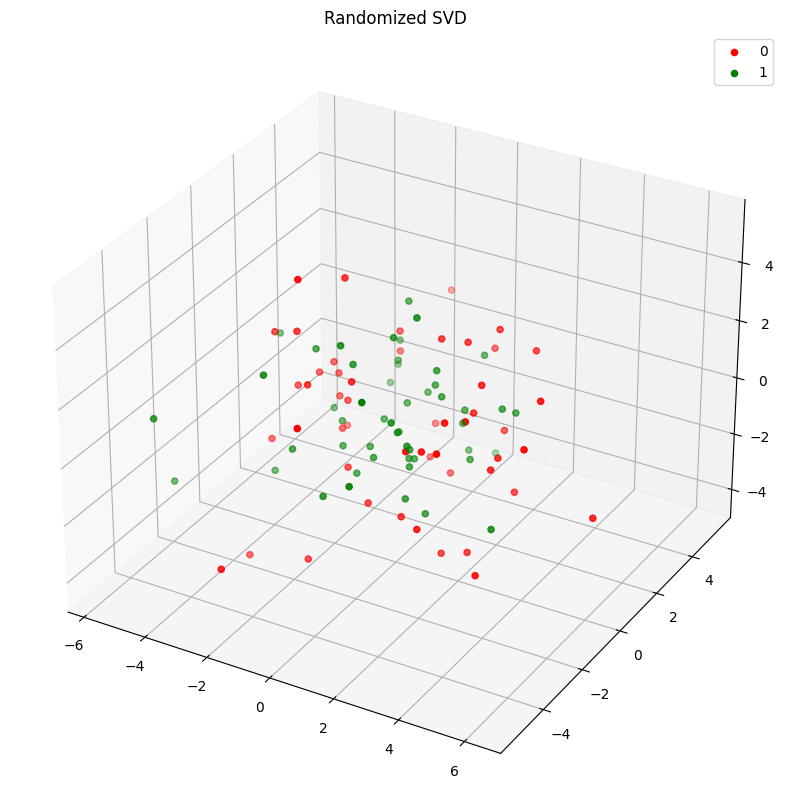

0.5926991391522283 0.09616794843949286


In [58]:
reducer=PCA(n_components=3,svd_solver='randomized')
X_=reducer.fit_transform(X)
f1s[2],stds[2]=estimate(X_,y)
visualize(X_,y,'Randomized SVD')
print(f1s[2],stds[2])
methods.append('Randomized SVD')

## **IncrementalPCA**

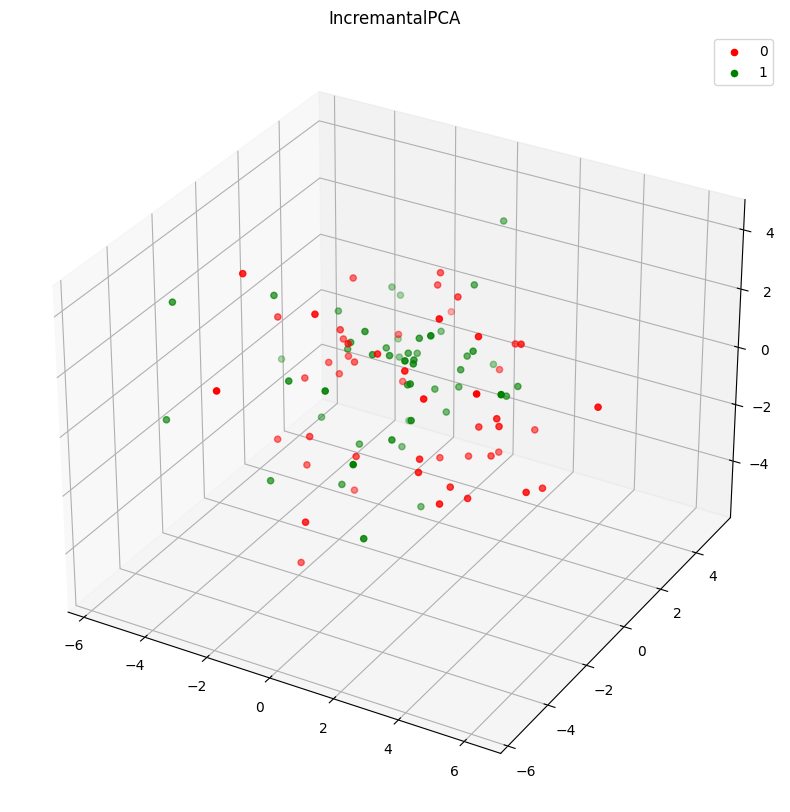

0.6365465838509317 0.08583325616953909


In [59]:
reducer=IncrementalPCA(n_components=3)
X_=reducer.fit_transform(X)
f1s[3],stds[3]=estimate(X_,y)
visualize(X_,y,'IncremantalPCA')
print(f1s[3],stds[3])
methods.append('IncremantalPCA')

## **SparsePCA**

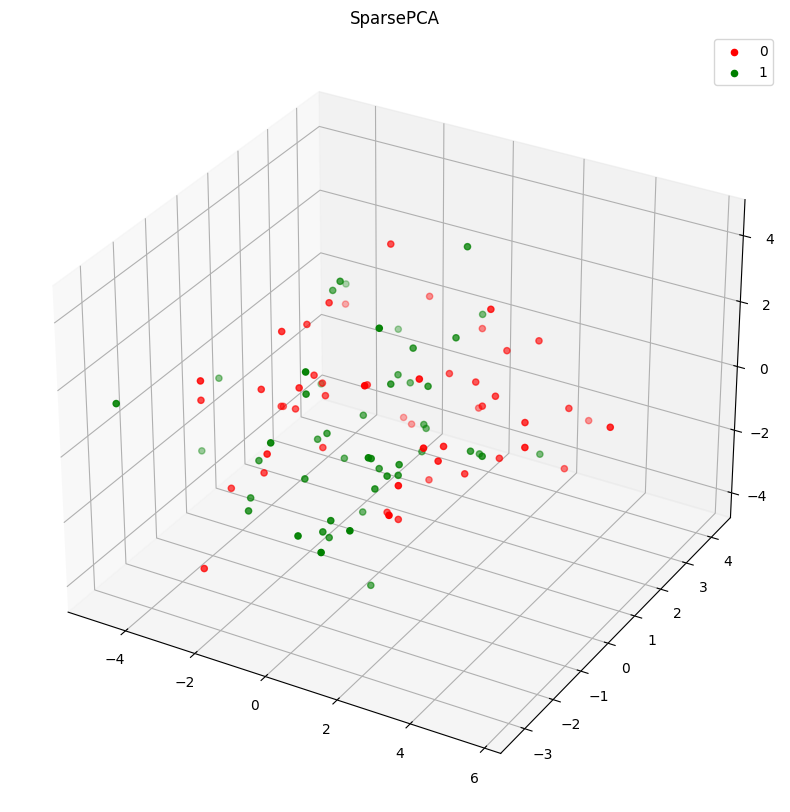

0.6750724637681158 0.03561091049130511


In [60]:
reducer=SparsePCA(n_components=3)
X_=reducer.fit_transform(X)
f1s[4],stds[4]=estimate(X_,y)
visualize(X_,y,'SparsePCA')
print(f1s[4],stds[4])
methods.append('SparsePCA')

## **MiniBatchSparsePCA**

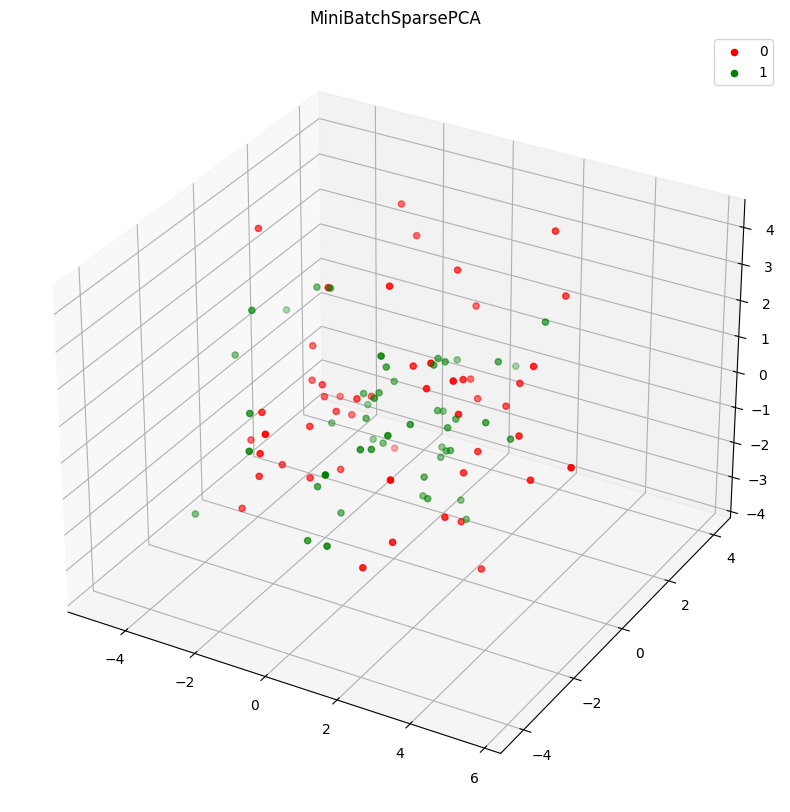

0.6463986052086738 0.04263245450155993


In [61]:
reducer=MiniBatchSparsePCA(n_components=3)
X_=reducer.fit_transform(X)
f1s[5],stds[5]=estimate(X_,y)
visualize(X_,y,'MiniBatchSparsePCA')
print(f1s[5],stds[5])
methods.append('MiniBatchSparsePCA')

## **KernelPCA**

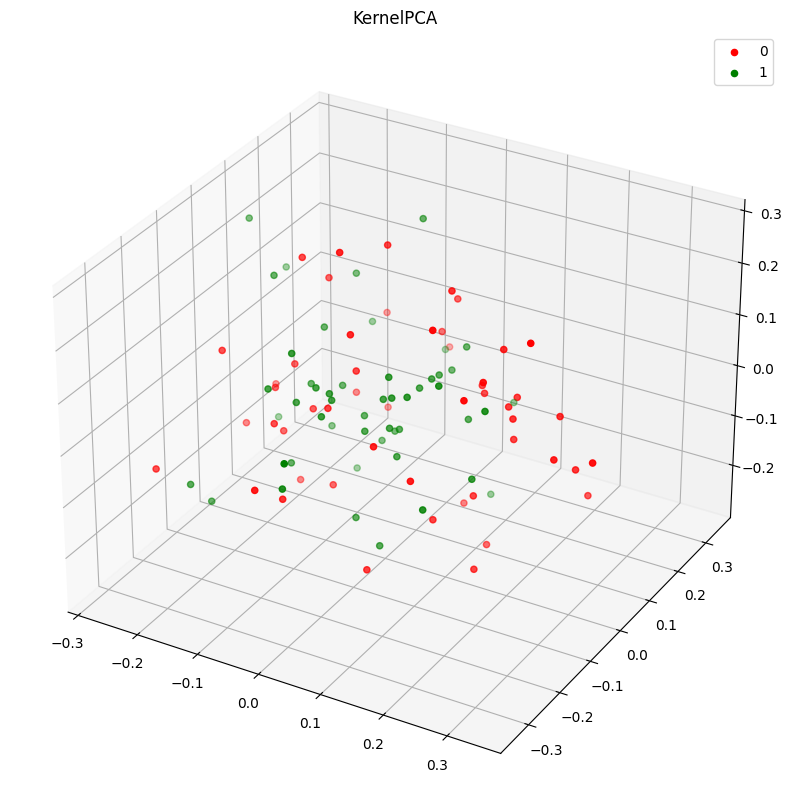

0.5431295047663334 0.0722582846806556


In [62]:
reducer=KernelPCA(n_components=3,kernel='rbf')
X_=reducer.fit_transform(X)
f1s[6],stds[6]=estimate(X_,y)
visualize(X_,y,'KernelPCA')
print(f1s[6],stds[6])
methods.append('KernelPCA')

## **TruncatedSVD**

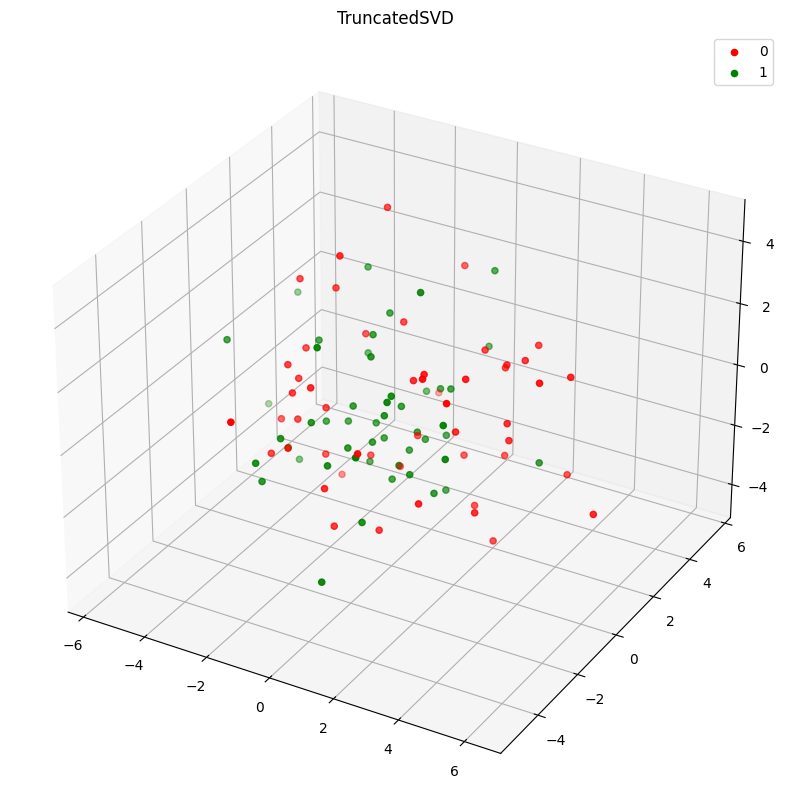

0.608029956313709 0.08532884693203777


In [63]:
reducer=TruncatedSVD(n_components=3)
X_=reducer.fit_transform(X)
f1s[7],stds[7]=estimate(X_,y)
visualize(X_,y,'TruncatedSVD')
print(f1s[7],stds[7])
methods.append('TruncatedSVD')

## **Dictionary Learning**

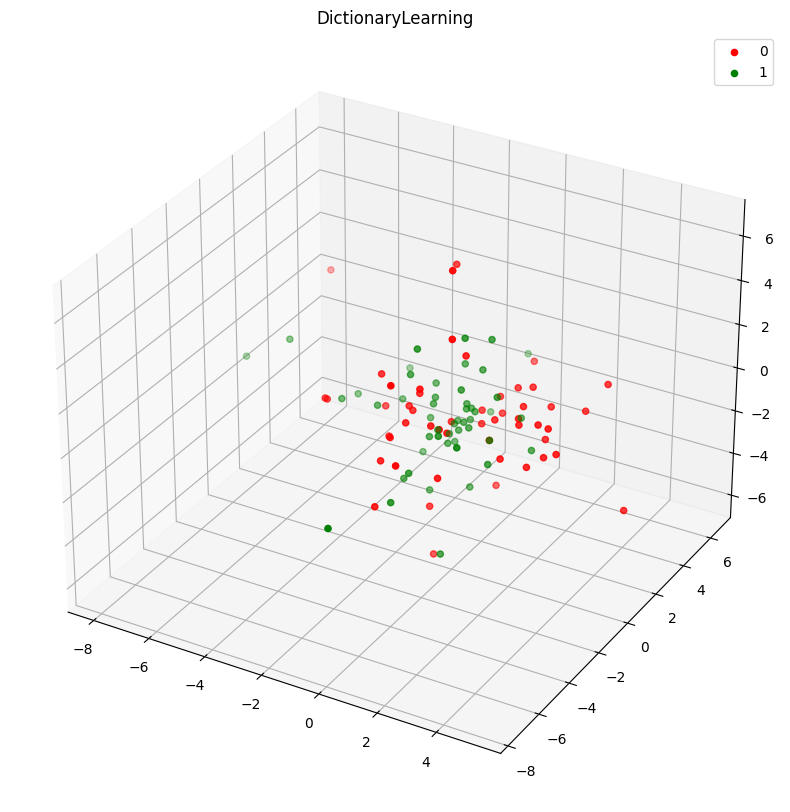

0.5879298245614035 0.14574774668337423


In [64]:
reducer=DictionaryLearning(n_components=3)
X_=reducer.fit_transform(X)
f1s[8],stds[8]=estimate(X_,y)
visualize(X_,y,'DictionaryLearning')
print(f1s[8],stds[8])
methods.append('DictionaryLearning')

## **MiniBatchDictionaryLearning**

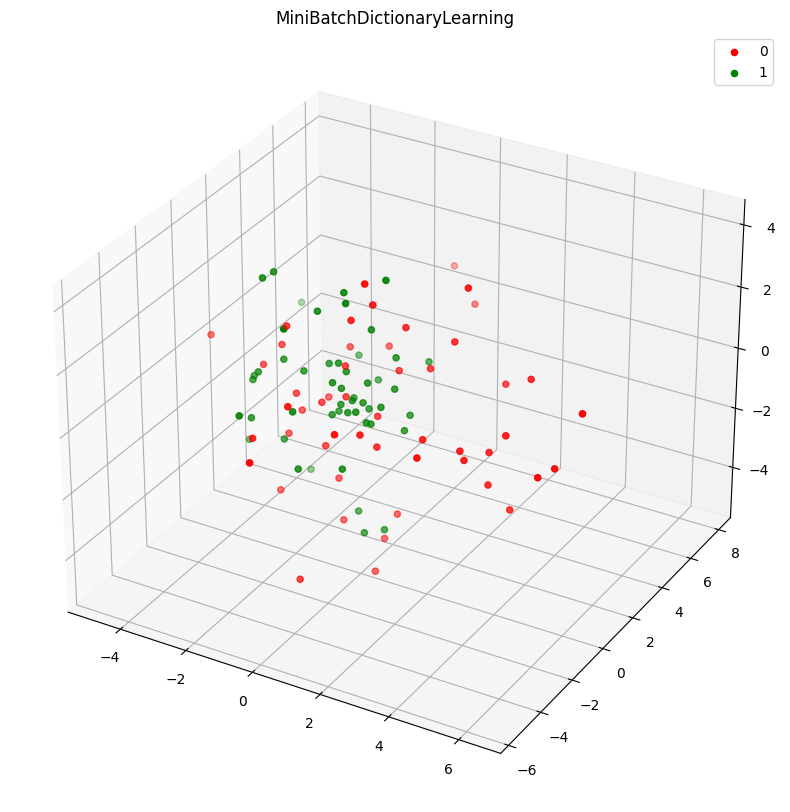

0.6073057038732095 0.11509035043418674


In [65]:
reducer=MiniBatchDictionaryLearning(n_components=3)
X_=reducer.fit_transform(X)
f1s[9],stds[9]=estimate(X_,y)
visualize(X_,y,'MiniBatchDictionaryLearning')
print(f1s[9],stds[9])
methods.append('MiniBatchDictionaryLearning')

## **FactorAnalysis**

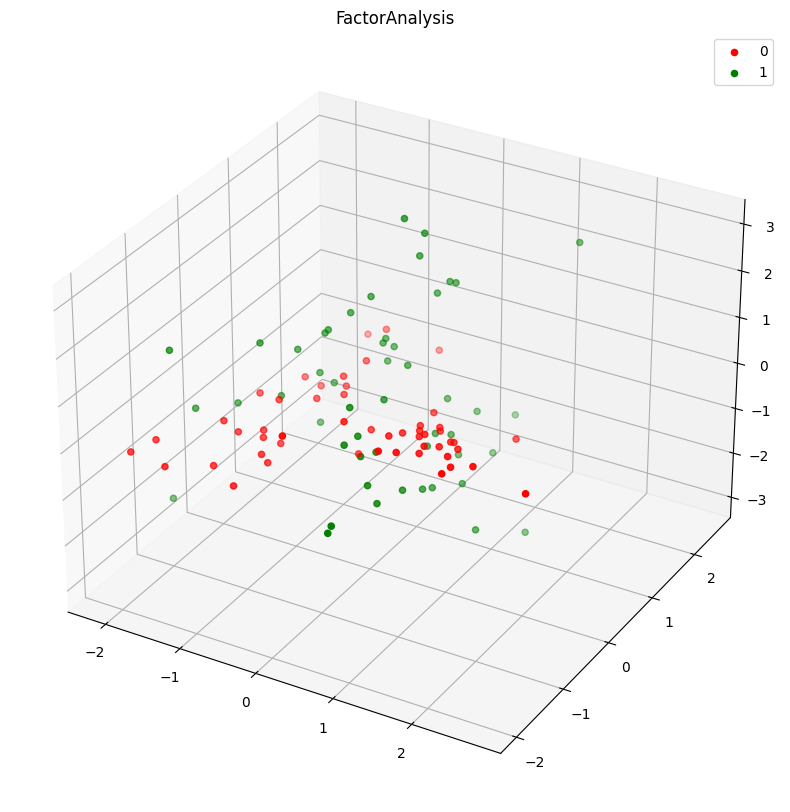

0.7546060606060607 0.05837103071570344


In [66]:
reducer=FactorAnalysis(n_components=3)
X_=reducer.fit_transform(X)
f1s[10],stds[10]=estimate(X_,y)
visualize(X_,y,'FactorAnalysis')
print(f1s[10],stds[10])
methods.append('FactorAnalysis')

## **ICA**

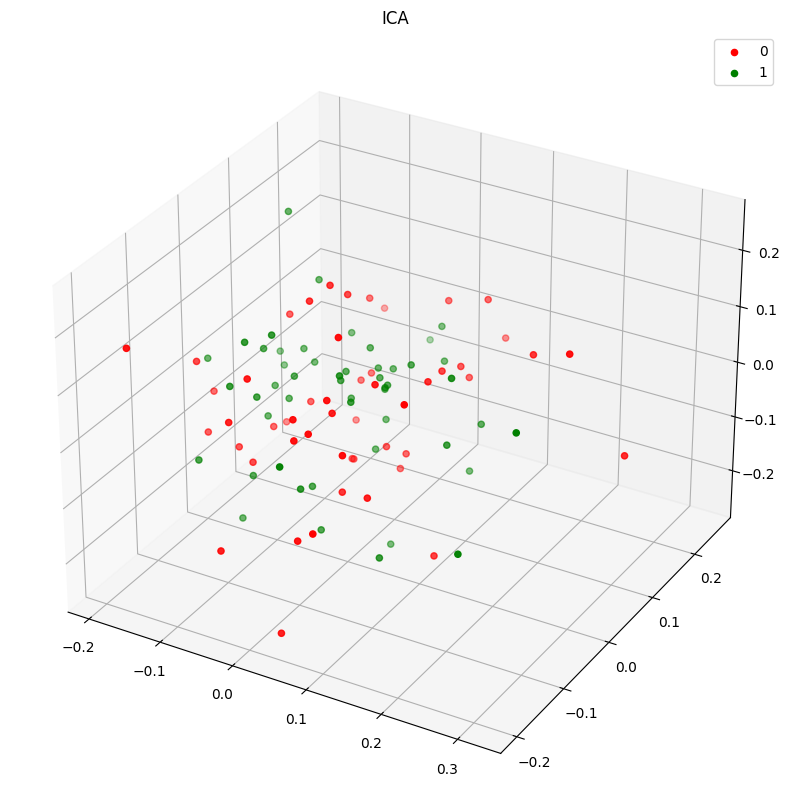

0.6291839107184376 0.1636599125756875


In [67]:
reducer=FastICA(n_components=3)
X_=reducer.fit_transform(X)
f1s[11],stds[11]=estimate(X_,y)
visualize(X_,y,'ICA')
print(f1s[11],stds[11])
methods.append('ICA')

## **NMF**

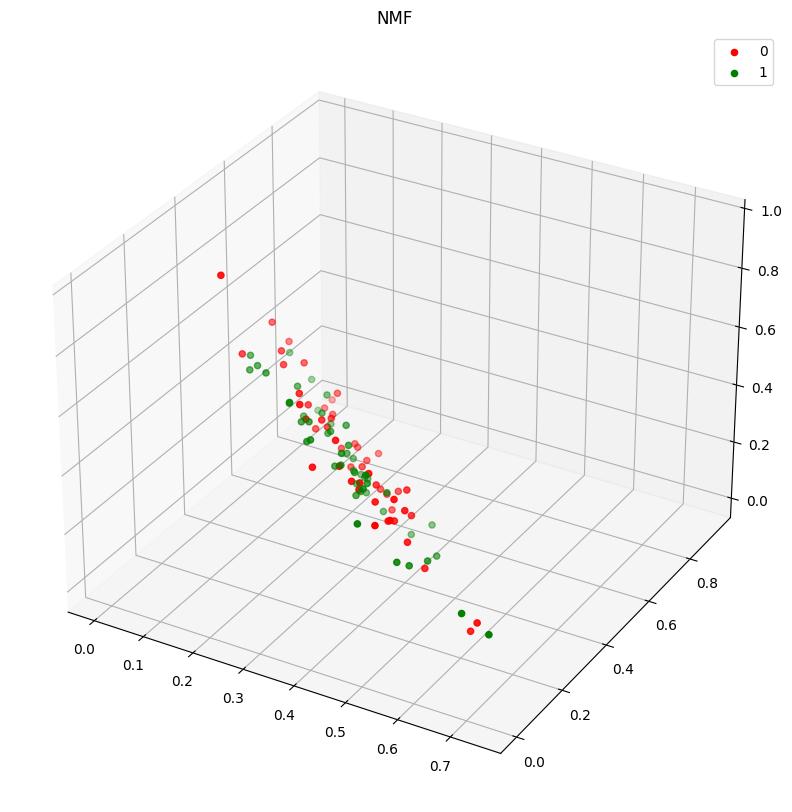

0.5991341991341991 0.08022568941028833


In [68]:
reducer=NMF(n_components=3)
X_=reducer.fit_transform(X__)
f1s[12],stds[12]=estimate(X_,y)
visualize(X_,y,'NMF')
print(f1s[12],stds[12])
methods.append('NMF')

## **LatentDirichletAllocation**

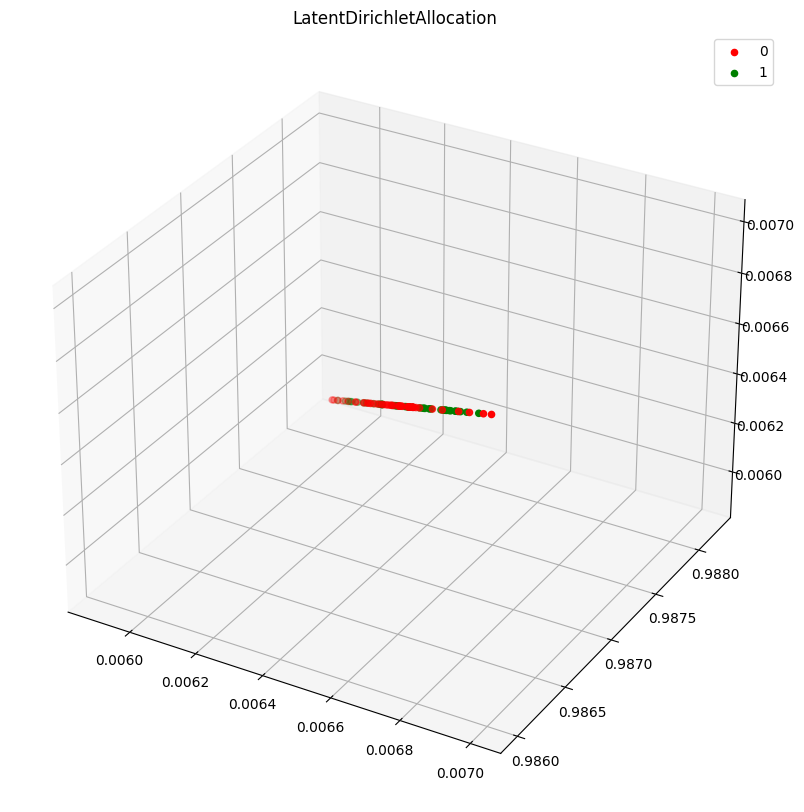

0.549260138838144 0.09982058297961906


In [69]:
reducer=LatentDirichletAllocation(n_components=3)
X_=reducer.fit_transform(X__)
f1s[13],stds[13]=estimate(X_,y)
visualize(X_,y,'LatentDirichletAllocation')
print(f1s[13],stds[13])
methods.append('LatentDirichletAllocation')

## **LinearDiscriminantAnalysis**

In [70]:
reducer=LinearDiscriminantAnalysis(n_components=1)
X_=reducer.fit(X,y).transform(X)
print(X_)
f1s[14],stds[14]=estimate(X_,y)
print(f1s[14],stds[14])
methods.append('LinearDiscriminantAnalysis')

[[-217.04265695]
 [-218.41077024]
 [-218.09455956]
 [ 222.18615583]
 [-217.64954995]
 [-219.35811647]
 [-217.08264192]
 [ 221.07858373]
 [-219.42374958]
 [ 221.2562411 ]
 [ 221.83269073]
 [ 221.84144907]
 [ 224.4345849 ]
 [-217.68744535]
 [-217.243554  ]
 [-218.11835748]
 [-217.35725412]
 [-217.66065213]
 [-219.74710513]
 [-218.64006781]
 [ 224.81960082]
 [-217.98651653]
 [ 222.58128839]
 [ 222.20254949]
 [-216.683093  ]
 [ 222.49411408]
 [-218.99209796]
 [-219.51122093]
 [ 223.68972983]
 [-215.86288367]
 [ 221.83367201]
 [-217.14050147]
 [-217.21470229]
 [ 222.7421899 ]
 [-217.3592351 ]
 [ 222.49775735]
 [ 221.6480845 ]
 [ 221.76983898]
 [-218.12166893]
 [-217.32383212]
 [ 223.28995102]
 [-217.17763062]
 [ 221.6484349 ]
 [-216.21265367]
 [-218.85640347]
 [-218.80107246]
 [ 221.34355774]
 [ 223.66171103]
 [ 221.91385133]
 [-216.82147562]
 [-218.13455703]
 [ 222.31324561]
 [-217.42766782]
 [ 221.04479027]
 [ 220.82533435]
 [ 222.52023234]
 [-218.85676033]
 [-219.08908052]
 [-219.3623553

## **AutoEncoder with linear activations**

Model: "linear_auto_encoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3848
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step - loss: 0.3726
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3616
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3516
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3426
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3345
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3274
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3211
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3154
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3105
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3061
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3021
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2986
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2954
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2924
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━

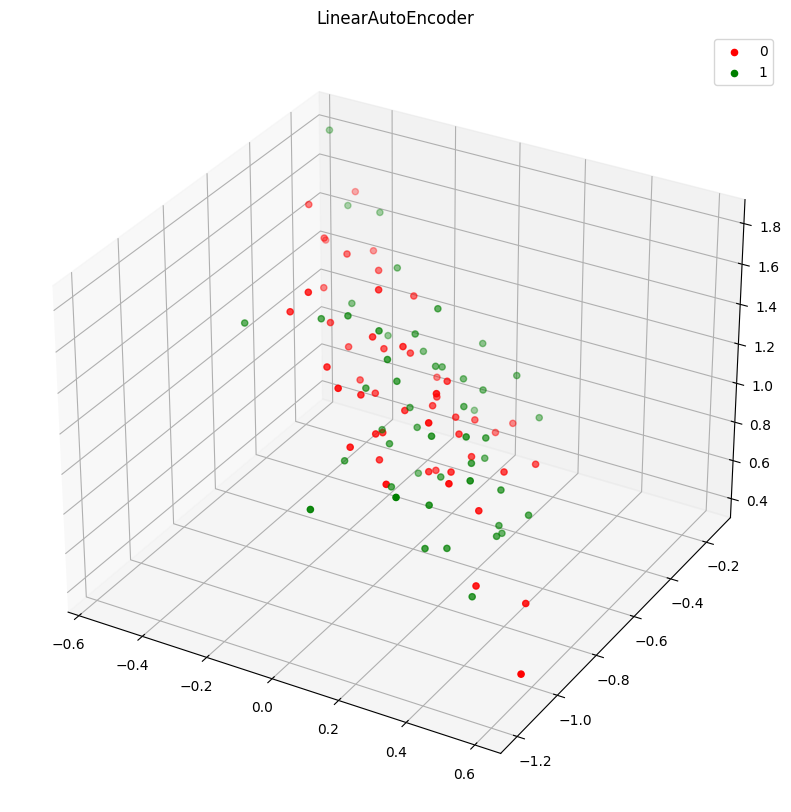

0.47679779158040025 0.09749649644782359


In [71]:
model=LinearAutoEncoder(input_dim=X.shape[1])
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError())
model.summary()
hist=model.fit(X__,X__,epochs=50,batch_size=128)
reducer=model.encoder
X_=reducer(X__).numpy()
f1s[15],stds[15]=estimate(X_,y)
visualize(X_,y,'LinearAutoEncoder')
print(f1s[15],stds[15])
methods.append('LinearAutoEncoder')

## **AutoEncoder with non-linear activations**

Model: "non_linear_auto_encoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3140
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - loss: 0.3100
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3067
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3038
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3014
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2993
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2974
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2956
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2938
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2920
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2902
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2883
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2864
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2845
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2825
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━

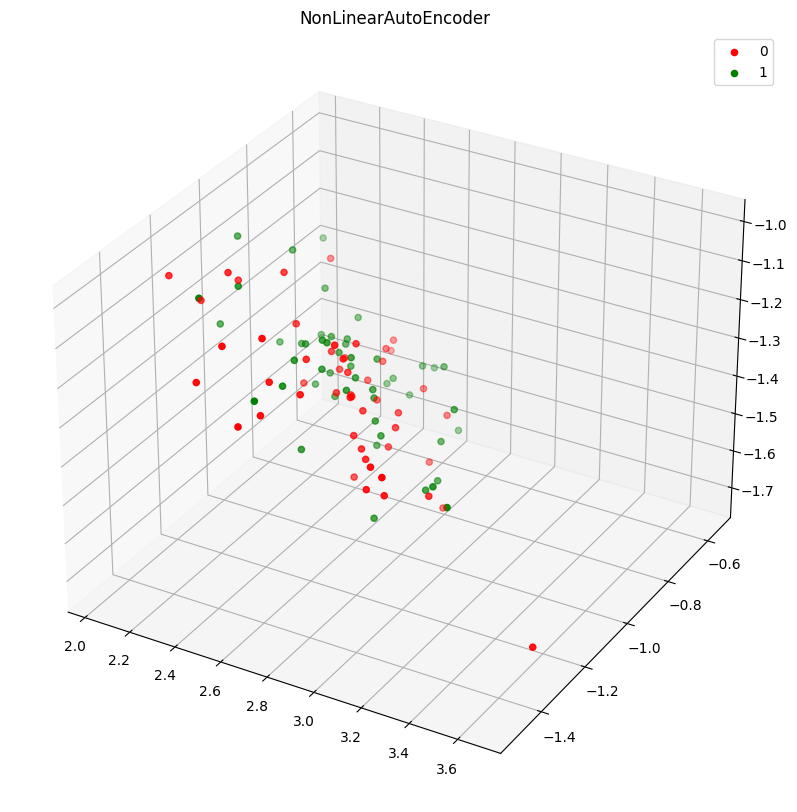

0.5332631578947368 0.11858826920528678


In [72]:
model=NonLinearAutoEncoder(input_dim=X.shape[1])
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError())
model.summary()
hist=model.fit(X__,X__,epochs=50,batch_size=128)
reducer=model.encoder
X_=reducer(X__).numpy()
f1s[16],stds[16]=estimate(X_,y)
visualize(X_,y,'NonLinearAutoEncoder')
print(f1s[16],stds[16])
methods.append('NonLinearAutoEncoder')

## **Visualizing overall perfomance across methods**

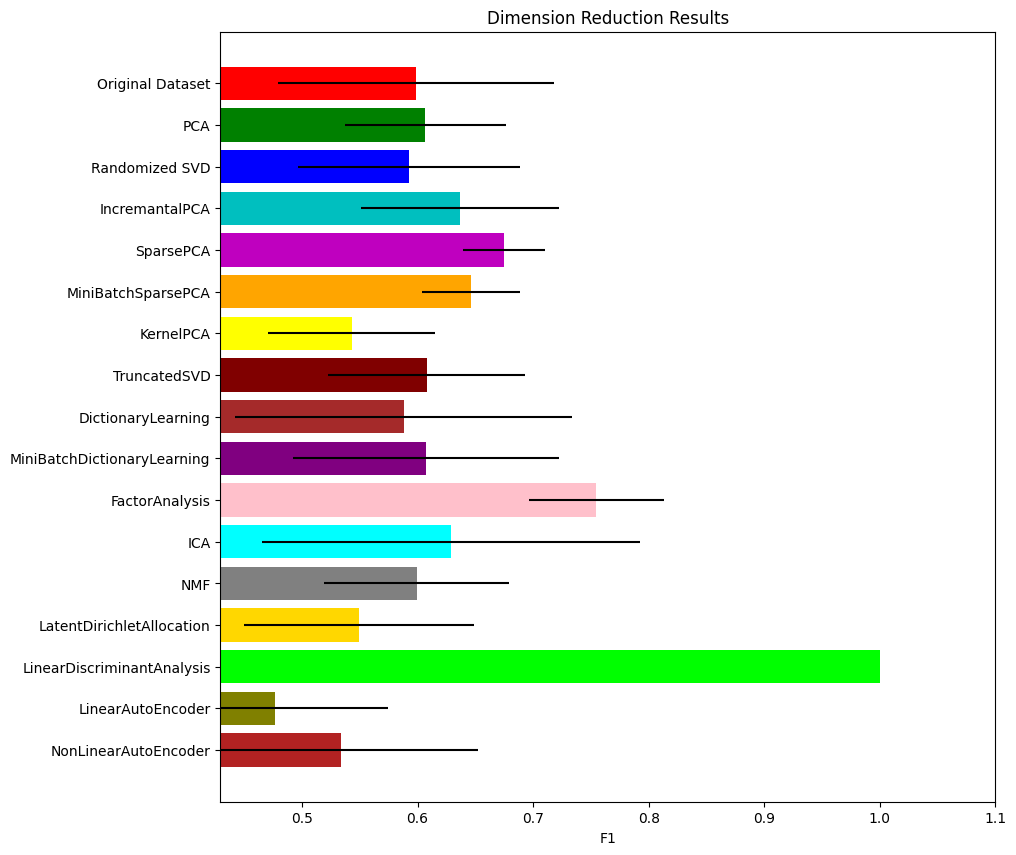

In [73]:
n_bars=len(f1s)
colors=["r", "g", "b", "c", "m",'orange','yellow','maroon','brown','purple','pink','aqua','gray','gold','lime','olive','firebrick']
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
for j in range(n_bars):
    ax.barh(j,f1s[j],xerr=stds[j],color=colors[j],align="center")
ax.set_title("Dimension Reduction Results")
ax.set_xlim(left=np.min(f1s)* 0.9,right=np.max(f1s)*1.1)
ax.set_yticks(range(n_bars))
ax.set_xlabel("F1")
ax.invert_yaxis()
x_labels=methods
ax.set_yticklabels(x_labels)
plt.show()